### Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

import re
# !pip install nlp-id
# from nlp_id.stopword import StopWord
# from nlp_id.lemmatizer import Lemmatizer

!pip install nltk
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

from collections import Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from wordcloud import WordCloud

Mounted at /content/drive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
!pip install transformers datasets torch scikit-learn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, default_data_collator, EarlyStoppingCallback
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from datasets import Dataset, DatasetDict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Scrapping Text Berita

## Liputan 6

In [ ]:
# List kategori dengan URL dan label masing-masing
categories = [
    {"url": "https://www.liputan6.com/bola/liga-inggris", "label": "Liga Inggris"},
    {"url": "https://www.liputan6.com/bola/liga-nasional", "label": "Liga Indonesia"},
    {"url": "https://www.liputan6.com/bola/liga-spanyol", "label": "Liga Spanyol"},
    {"url": "https://www.liputan6.com/bola/liga-italia", "label": "Liga Italia"},
    {"url": "https://www.liputan6.com/bola/sports", "label": "Olahraga Non Sepak Bola"},
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Fungsi untuk mendapatkan link artikel dari satu halaman
def get_article_links(page_url):
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")
    articles = soup.find_all("a", class_="ui--a articles--iridescent-list--text-item__title-link")
    return [article["href"] for article in articles if "href" in article.attrs]

# Fungsi untuk mengambil konten artikel
def scrape_article(link):
    try:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        # Cari judul artikel
        title_tag = soup.find("h1", class_="read-page--header--title entry-title")
        title = title_tag.text.strip() if title_tag else "Judul tidak ditemukan"

        # Cari elemen konten utama
        content_container = soup.find_all("div", class_="article-content-body__item-content")

        # Ambil semua paragraf dari kontainer konten
        paragraphs = [
            p.text.strip()
            for div in content_container
            for p in div.find_all("p") if p.text.strip()
        ]

        # Gabungkan paragraf menjadi satu string
        content = "\n".join(paragraphs)
        return title, content
    except Exception as e:
        print(f"Error scraping article: {e}")
        return None, None

# Variabel untuk menyimpan semua data
all_data = []

# Loop untuk setiap kategori
for category in categories:
    base_url = category["url"]
    label = category["label"]
    scraped_links = set()  # Set untuk melacak link yang sudah di-scrape

    print(f"Scraping kategori: {label}...")
    article_links = get_article_links(base_url)

    for link in article_links:
        if link not in scraped_links:
            title, content = scrape_article(link)
            print(f"    Judul: {title}, Konten: {content[:100] if content else 'Tidak ada konten'}")
            if title and content:  # Skip if no content
                all_data.append({
                    "Title": title,
                    "Teks": content,
                    "Media": "Liputan6.com",
                    "Label": label,
                    "Link": link
                })
                scraped_links.add(link)

# Simpan ke CSV di Google Drive
if all_data:

    save_path = "/content/drive/My Drive/UAS TM/Dataset_Liputan6.csv"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    df = pd.DataFrame(all_data)
    df.to_csv(save_path, index=False, encoding="utf-8")
    print(f"Dataset berhasil disimpan di {save_path}.")

else:
    print("Tidak ada data yang berhasil di-scrape.")

Scraping kategori: Liga Inggris...
    Judul: Butuh Amunisi Baru, Manchester United Berharap Belas Kasihan Barcelona, Konten: Liputan6.com, Jakarta- Manchester United masih berupaya untuk mendatangkan pemain baru di sisa dua m
    Judul: Hasil Liga Inggris: Manchester United Comeback Gemilang di Old Trafford, Brighton Curi Poin, Konten: Liputan6.com, Jakarta Manchester United melakukan comeback gemilang saat menjamu Southampton pada pe
    Judul: Link Live Streaming Liga Inggris Manchester United vs Southampton, Sebentar Lagi Tayang di Vidio, Konten: Liputan6.com, Jakarta - Manchester United dan Southampton bertarung pada persaingan Liga Inggris 202
    Judul: Link Live Streaming Liga Inggris Manchester United vs Southampton, Jumat 17 Januari 2025 Pukul 03.00 WIB di Vidio, Konten: Liputan6.com, Jakarta - Manchester United menghadapi Southampton pada pekan ke-21 Liga Inggris 2024/
    Judul: Manchester United Punya Talenta Emas 16 Tahun, Digadang Mirip Xavi dan Siap Susul Mainoo, Konten

In [48]:
df_liputan6 = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_Liputan6.csv")
df_liputan6.head(5)

,Title,Teks,Media,Label,Link
0,"Butuh Amunisi Baru, Manchester United Berharap...","Liputan6.com, Jakarta- Manchester United masih...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884046/but...
1,Hasil Liga Inggris: Manchester United Comeback...,"Liputan6.com, Jakarta Manchester United melaku...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884293/has...
2,Link Live Streaming Liga Inggris Manchester Un...,"Liputan6.com, Jakarta - Manchester United dan ...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884127/lin...
3,Link Live Streaming Liga Inggris Manchester Un...,"Liputan6.com, Jakarta - Manchester United meng...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884125/lin...
4,"Manchester United Punya Talenta Emas 16 Tahun,...","Liputan6.com, Jakarta- Pembenahan di tim akade...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5883681/man...


In [ ]:
df_liputan6['Label'].value_counts()

,count
Label,
Liga Inggris,57
Liga Indonesia,57
Olahraga Non Sepak Bola,57
Liga Spanyol,30
Liga Italia,30


## Detik

In [ ]:
# List kategori dengan URL dan label masing-masing
categories = [
    {"url": "https://sport.detik.com/sepakbola/liga-inggris", "label": "Liga Inggris"},
    {"url": "https://sport.detik.com/sepakbola/liga-indonesia", "label": "Liga Indonesia"},
    {"url": "https://sport.detik.com/sepakbola/liga-spanyol", "label": "Liga Spanyol"},
    {"url": "https://sport.detik.com/sepakbola/liga-italia", "label": "Liga Italia"},
    {"url": "https://sport.detik.com/sport-lain", "label": "Olahraga Non Sepak Bola"},
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Fungsi untuk mendapatkan link artikel dari satu halaman
def get_article_links(page_url):
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    # Menemukan semua elemen <a> yang mengarah ke artikel
    articles = soup.find_all("a", class_="media__link")
    return [article["href"] for article in articles if "href" in article.attrs]

# Fungsi untuk mengambil konten artikel
def scrape_article(link):
    try:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        # Cari judul artikel
        title_tag = soup.find("h1", class_="detail__title")
        title = title_tag.text.strip() if title_tag else "Judul tidak ditemukan"

        # Cari elemen konten utama
        content_container = soup.find("div", class_="detail__body-text itp_bodycontent")

        # Ambil semua paragraf dari kontainer konten
        paragraphs = [
            p.text.strip()
            for p in content_container.find_all("p") if p.text.strip()
        ] if content_container else []

        # Gabungkan paragraf menjadi satu string
        content = "\n".join(paragraphs)
        return title, content
    except Exception as e:
        print(f"Error scraping article: {e}")
        return None, None

# Variabel untuk menyimpan semua data
all_data = []

# Loop untuk setiap kategori
for category in categories:
    base_url = category["url"]
    label = category["label"]
    scraped_links = set()  # Set untuk melacak link yang sudah di-scrape

    print(f"Scraping kategori: {label}...")
    article_links = get_article_links(base_url)

    for link in article_links:
        if link not in scraped_links:
            title, content = scrape_article(link)
            print(f"    Judul: {title}, Konten: {content[:100] if content else 'Tidak ada konten'}")
            if title and content:  # Skip if no content
                all_data.append({
                    "Title": title,
                    "Teks": content,
                    "Media": "Liputan6.com",
                    "Label": label,
                    "Link": link
                })
                scraped_links.add(link)

# Simpan ke CSV di Google Drive
if all_data:
    save_path = "/content/drive/My Drive/UAS TM/Dataset_Detik.csv"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    df = pd.DataFrame(all_data)
    df.to_csv(save_path, index=False, encoding="utf-8")
    print(f"Dataset berhasil disimpan di {save_path}.")

else:
    print("Tidak ada data yang berhasil di-scrape.")

Scraping kategori: Liga Inggris...
    Judul: Resmi! Khvicha Kvaratskhelia Gabung PSG, Konten: Paris Saint-Germain secara resmi mengumumkan transfer Khvicha Kvaratskhelia dari Napoli. Kvaratskhel
    Judul: MU Berduka, Eks Striker Denis Law Meninggal Dunia, Konten: Denis Law, mantan striker tajam Manchester United, meninggal dunia. Legenda asal Skotlandia itu meng
    Judul: Kejutan! Chelsea Ingin Bajak Alejandro Garnacho dari MU, Konten: Chelsea membuat kejutan di bursa transfer Januari ini. The Blues ingin membajak Alejandro Garnacho d
    Judul: Al Taawoun Vs Al Nassr: Ditahan 1-1, Ronaldo dkk Terlempar dari 3 Besar, Konten: Al Nassr ditahan Al Taawoun 1-1 dalam lanjutan Saudi Pro League 2024/2025. Cristiano Ronaldo dkk sem
    Judul: Neymar: Mbappe Cemburu dengan Kedatangan Messi, Konten: Kedatangan Lionel Messi ke Paris Saint-Germain rupanya menimbulkan perpecahan. Sebab, Kylian Mbappe 
    Judul: Brentford Vs Liverpool Imbang di Babak Pertama, Konten: Belum ada gol tercipta dalam

In [49]:
df_detik = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_Detik.csv")
df_detik.head(5)

,Title,Teks,Media,Label,Link
0,Resmi! Khvicha Kvaratskhelia Gabung PSG,Paris Saint-Germain secara resmi mengumumkan t...,Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/bola-dunia/d...
1,"MU Berduka, Eks Striker Denis Law Meninggal Dunia","Denis Law, mantan striker tajam Manchester Uni...",Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/liga-inggris...
2,Kejutan! Chelsea Ingin Bajak Alejandro Garnach...,Chelsea membuat kejutan di bursa transfer Janu...,Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/liga-inggris...
3,"Al Taawoun Vs Al Nassr: Ditahan 1-1, Ronaldo d...",Al Nassr ditahan Al Taawoun 1-1 dalam lanjutan...,Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/bola-dunia/d...
4,Neymar: Mbappe Cemburu dengan Kedatangan Messi,Kedatangan Lionel Messi ke Paris Saint-Germain...,Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/bola-dunia/d...


In [ ]:
df_detik['Label'].value_counts()

,count
Label,
Liga Italia,64
Liga Spanyol,63
Liga Indonesia,62
Olahraga Non Sepak Bola,62
Liga Inggris,58


## Antara News

In [ ]:
# List kategori dengan URL dan label masing-masing
categories = [
    {"url": "https://www.antaranews.com/sepakbola/liga-inggris-premier", "label": "Liga Inggris"},
    {"url": "https://www.antaranews.com/sepakbola/liga-indonesia", "label": "Liga Indonesia"},
    {"url": "https://www.antaranews.com/sepakbola/liga-spanyol", "label": "Liga Spanyol"},
    {"url": "https://www.antaranews.com/sepakbola/liga-italia-seri-a", "label": "Liga Italia"},
    {"url": "https://www.antaranews.com/olahraga/all-sport", "label": "Olahraga Non Sepak Bola"},
]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
}

# Fungsi untuk mendapatkan link artikel dari satu halaman
def get_article_links(page_url):
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    # Menemukan semua elemen <a> yang mengarah ke artikel
    articles = soup.find_all("a", href=True, title=True)
    return [{"link": article["href"], "title": article["title"]} for article in articles if "/berita/" in article["href"]]

# Fungsi untuk mengambil konten artikel
def scrape_article(link):
    try:
        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        # Cari elemen konten utama
        content_container = soup.find("div", class_="wrap__article-detail-content post-content")
        paragraphs = [
            p.text.strip()
            for p in content_container.find_all("p") if p.text.strip()
        ] if content_container else []

        # Gabungkan paragraf menjadi satu string
        content = "\n".join(paragraphs) if paragraphs else "Tidak ada konten"
        return content
    except Exception as e:
        print(f"Error scraping article: {e}")
        return None

# Variabel untuk menyimpan semua data
all_data = []

# Loop untuk setiap kategori
for category in categories:
    base_url = category["url"]
    label = category["label"]
    scraped_links = set()  # Set untuk melacak link yang sudah di-scrape

    print(f"Scraping kategori: {label}...")
    article_links = get_article_links(base_url)

    for article in article_links:
        link = article["link"]
        title = article["title"]
        if link not in scraped_links:
            content = scrape_article(link)
            # Skip jika konten tidak valid
            if content == "Tidak ada konten":
                print(f"    Skip artikel: Konten tidak valid.")
                continue

            print(f"    Judul: {title}, Konten: {content[:100]}...")
            all_data.append({
                "Title": title,
                "Teks": content,
                "Media": "AntaraNews.com",
                "Label": label,
                "Link": link
            })
            scraped_links.add(link)

# Simpan ke CSV di Google Drive
if all_data:
    save_path = "/content/drive/My Drive/UAS TM/Dataset_AntaraNews.csv"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    df = pd.DataFrame(all_data)
    df.to_csv(save_path, index=False, encoding="utf-8")
    print(f"Dataset berhasil disimpan di {save_path}.")

else:
    print("Tidak ada data yang berhasil di-scrape.")

Scraping kategori: Liga Inggris...
    Judul: Guardiola: Kehebatan Haaland sebanding Messi dan Ronaldo, Konten: Jakarta (ANTARA) - Pelatih Manchester City Josep "Pep" Guardiola mengatakan kehebatan Erling Haaland...
    Judul: Legenda Manchester United Denis Law tutup usia, Konten: Jakarta (ANTARA) - Legenda Manchester United dan Skotlandia, Denis Law, wafat dalam usia 84 tahun, d...
    Judul: Diogo Jota diragukan tampil saat Liverpool hadapi Brentford, Konten: Jakarta (ANTARA) - Pelatih Liverpool Arne Slot mengungkapkan Diogo Jota mungkin absen  dalam pertand...
    Judul: Amorim: Saya ingin pertahankan pemain di bursa transfer ini, Konten: Jakarta (ANTARA) - Pelatih Manchester United Ruben Amorim menginginkan pemainnya tetap dipertahankan...
    Judul: Chelsea dirumorkan incar Karim Adeyemi, Konten: Jakarta (ANTARA) - Chelsea dirumorkan mengincar penyerang Borussia Dortmund Karim Adeyemi.
Dalam lap...
    Judul: Kontrak Haaland di Manchester City pecahkan rekor, Konten: Jakarta (ANT

In [50]:
df_antaranews = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_AntaraNews.csv")
df_antaranews.head(5)

,Title,Teks,Media,Label,Link
0,Guardiola: Kehebatan Haaland sebanding Messi d...,Jakarta (ANTARA) - Pelatih Manchester City Jos...,AntaraNews.com,Liga Inggris,https://www.antaranews.com/berita/4592326/guar...
1,Legenda Manchester United Denis Law tutup usia,Jakarta (ANTARA) - Legenda Manchester United d...,AntaraNews.com,Liga Inggris,https://www.antaranews.com/berita/4592062/lege...
2,Diogo Jota diragukan tampil saat Liverpool had...,Jakarta (ANTARA) - Pelatih Liverpool Arne Slot...,AntaraNews.com,Liga Inggris,https://www.antaranews.com/berita/4591918/diog...
3,Amorim: Saya ingin pertahankan pemain di bursa...,Jakarta (ANTARA) - Pelatih Manchester United R...,AntaraNews.com,Liga Inggris,https://www.antaranews.com/berita/4591714/amor...
4,Chelsea dirumorkan incar Karim Adeyemi,Jakarta (ANTARA) - Chelsea dirumorkan menginca...,AntaraNews.com,Liga Inggris,https://www.antaranews.com/berita/4591674/chel...


In [ ]:
df_antaranews['Label'].value_counts()

,count
Label,
Olahraga Non Sepak Bola,33
Liga Inggris,31
Liga Spanyol,31
Liga Italia,31
Liga Indonesia,30


## Merge

Selanjutnya adalah menggabungkan ketiga DataFrame dari ketiga jenis website yang telah berhasil di scrapping menjadi 1 DataFrame

In [ ]:
df_combined = pd.concat([df_liputan6, df_detik, df_antaranews], ignore_index=True)

save_path = "/content/drive/My Drive/UAS TM/Dataset_Combined.csv"
df_combined.to_csv(save_path, index=False, encoding="utf-8")

df_combined.head(5)

,Title,Teks,Media,Label,Link
0,"Butuh Amunisi Baru, Manchester United Berharap...","Liputan6.com, Jakarta- Manchester United masih...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884046/but...
1,Hasil Liga Inggris: Manchester United Comeback...,"Liputan6.com, Jakarta Manchester United melaku...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884293/has...
2,Link Live Streaming Liga Inggris Manchester Un...,"Liputan6.com, Jakarta - Manchester United dan ...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884127/lin...
3,Link Live Streaming Liga Inggris Manchester Un...,"Liputan6.com, Jakarta - Manchester United meng...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5884125/lin...
4,"Manchester United Punya Talenta Emas 16 Tahun,...","Liputan6.com, Jakarta- Pembenahan di tim akade...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5883681/man...


In [ ]:
df_combined['Label'].value_counts()

,count
Label,
Olahraga Non Sepak Bola,152
Liga Indonesia,149
Liga Inggris,146
Liga Italia,125
Liga Spanyol,124


## Random Sampling

Untuk jumlah persebaran labelnya tidak seimbang, maka perlu dilakukan random sampling dengan mengambil sebanyak 120 data pada masing-masing label

In [ ]:
df_final = df_combined.groupby('Label').apply(lambda x: x.sample(n=120, random_state=42)).reset_index(drop=True)

save_path = "/content/drive/My Drive/UAS TM/Dataset_Final.csv"
df_final.to_csv(save_path, index=False, encoding="utf-8")

<ipython-input-44-4453dfa5cb1e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df_combined.groupby('Label').apply(lambda x: x.sample(n=120, random_state=42)).reset_index(drop=True)


In [ ]:
df_final['Label'].value_counts()

,count
Label,
Liga Indonesia,120
Liga Inggris,120
Liga Italia,120
Liga Spanyol,120
Olahraga Non Sepak Bola,120


## Load Merge Dataset

In [2]:
df = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_Final.csv")
df.head()

,Title,Teks,Media,Label,Link
0,Soccer Brain Dewa United yang Hancurkan Persib...,Persib Bandung akhirnya menelan kekalahan di L...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...
1,EKSKLUSIF Liputan6 SCTV: Patrick Kluivert Tida...,"Liputan6.com, Jakarta - Pelatih timnas Indones...",Liputan6.com,Liga Indonesia,https://www.liputan6.com/bola/read/5881688/eks...
2,"Real Madrid Vs Barcelona: Menang 5-2, Los Cule...",Barcelona menjuarai Piala Super Spanyol 2024. ...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-spanyol...
3,PSS Sleman Ungkap Rahasia Menang Beruntun,PSS Sleman sedang dalam tren positif. Super El...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...
4,Persib Vs Dewa United: Maung Bandung Kalah 0-2,Persib Bandung gagal meraih poin melawan Dewa ...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   600 non-null    object
 1   Teks    600 non-null    object
 2   Media   600 non-null    object
 3   Label   600 non-null    object
 4   Link    600 non-null    object
dtypes: object(5)
memory usage: 23.6+ KB


In [8]:
df_print = df[df["Label"] == "Olahraga Non Sepak Bola"]
df_print.head(5)

,Title,Teks,Media,Label,Link
480,Petarung UFC Ini Kecam Maskapai yang Usir Khab...,Heboh Khabib Nurmagomedov diusir dari pesawat....,Liputan6.com,Olahraga Non Sepak Bola,https://sport.detik.com/sport-lain/d-7735520/p...
481,"Lapangan licin, Bali United vs Prawira Bandung...",Jakarta (ANTARA) - Pertandingan lanjutan IBL 2...,AntaraNews.com,Olahraga Non Sepak Bola,https://www.antaranews.com/berita/4593170/lapa...
482,Tim Voli Putri Jakarta Livin' by Mandiri Siap ...,"Menyambut kompetisi voli Proliga 2025, Bank Ma...",Liputan6.com,Olahraga Non Sepak Bola,https://sport.detik.com/sport-lain/d-7706974/t...
483,Proliga 2025: Jakarta Livin Mandiri dan Samato...,Jakarta Livin Mandiri dan Samator Surabaya men...,Liputan6.com,Olahraga Non Sepak Bola,https://sport.detik.com/sport-lain/d-7717752/p...
484,Islam dan Merab pakai celana khusus saat perta...,Jakarta (ANTARA) - Dua juara Ultimate Fighting...,AntaraNews.com,Olahraga Non Sepak Bola,https://www.antaranews.com/berita/4589782/isla...


In [9]:
df_print = df[df["Label"] == "Liga Inggris"]
df_print.head(5)

,Title,Teks,Media,Label,Link
120,"Arsenal Tawar Murah Marcus Rashford, Mancheste...","Liputan6.com, Jakarta - Arsenal dilaporkan tel...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5877668/ars...
121,Pergantian Amorim Kunci MU Taklukkan Southampton!,Manchester United harus susah payah untuk mena...,Liputan6.com,Liga Inggris,https://sport.detik.com/sepakbola/liga-inggris...
122,"Manchester City Segera Boyong Talenta Brasil, ...","Liputan6.com, Jakarta - Raksasa Premier League...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5880572/man...
123,"Gara-gara Penyerang Ini, Harapan Pemain Manche...","Liputan6.com, Jakarta Marcus Rashford diperkir...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5881865/gar...
124,Hasil Piala FA Arsenal vs Manchester United: D...,"Liputan6.com, Jakarta - Juara bertahan Manches...",Liputan6.com,Liga Inggris,https://www.liputan6.com/bola/read/5878466/has...


In [10]:
df_print = df[df["Label"] == "Liga Indonesia"]
df_print.head(5)

,Title,Teks,Media,Label,Link
0,Soccer Brain Dewa United yang Hancurkan Persib...,Persib Bandung akhirnya menelan kekalahan di L...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...
1,EKSKLUSIF Liputan6 SCTV: Patrick Kluivert Tida...,"Liputan6.com, Jakarta - Pelatih timnas Indones...",Liputan6.com,Liga Indonesia,https://www.liputan6.com/bola/read/5881688/eks...
2,"Real Madrid Vs Barcelona: Menang 5-2, Los Cule...",Barcelona menjuarai Piala Super Spanyol 2024. ...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-spanyol...
3,PSS Sleman Ungkap Rahasia Menang Beruntun,PSS Sleman sedang dalam tren positif. Super El...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...
4,Persib Vs Dewa United: Maung Bandung Kalah 0-2,Persib Bandung gagal meraih poin melawan Dewa ...,Liputan6.com,Liga Indonesia,https://sport.detik.com/sepakbola/liga-indones...


In [11]:
df_print = df[df["Label"] == "Liga Spanyol"]
df_print.head(5)

,Title,Teks,Media,Label,Link
360,"Bantu Keluarga Tak Mampu Rayakan Natal 2024, L...","Liputan6.com, Jakarta- LaLiga kembali mengadak...",Liputan6.com,Liga Spanyol,https://www.liputan6.com/bola/read/5849757/ban...
361,Ancelotti: Salah Madrid Buka Jalan Celta Vigo,Real Madrid harus melakoni babak tambahan untu...,Liputan6.com,Liga Spanyol,https://sport.detik.com/sepakbola/liga-spanyol...
362,'Raphinha Kini Salah Satu Pemain Terbaik di Du...,Raphinha berangsur-angsur tidak tergantikan di...,Liputan6.com,Liga Spanyol,https://sport.detik.com/sepakbola/liga-spanyol...
363,Final Piala Super Spanyol: Misi Balas Dendam M...,Trofi juara Piala Super Spanyol tak sekadar da...,Liputan6.com,Liga Spanyol,https://sport.detik.com/sepakbola/liga-spanyol...
364,Hasil Lengkap Babak 16 Besar Copa del Rey Term...,Lima dari delapan partai di babak 16 besar Cop...,Liputan6.com,Liga Spanyol,https://sport.detik.com/sepakbola/liga-spanyol...


In [12]:
df_print = df[df["Label"] == "Liga Italia"]
df_print.head(5)

,Title,Teks,Media,Label,Link
240,Hasil Liga Italia Serie A: AC Milan dan Juvent...,"Liputan6.com, Jakarta Hasil kurang memuaskan d...",Liputan6.com,Liga Italia,https://www.liputan6.com/bola/read/5855856/has...
241,Romelu Lukaku Memang Paling Cocok sama Antonio...,Romelu Lukaku kembali menemukan ketajamannya d...,Liputan6.com,Liga Italia,https://sport.detik.com/sepakbola/liga-italia/...
242,"Lagi, Pesepakbola Serie A Tersandung Kasus Judi",Maduka Okoye diselidiki terkait dugaan judi se...,Liputan6.com,Liga Italia,https://sport.detik.com/sepakbola/liga-italia/...
243,Napoli Vs Verona: Partenopei Menang 2-0,Napoli menjaga diri dari tekanan di pucuk klas...,Liputan6.com,Liga Italia,https://sport.detik.com/sepakbola/liga-italia/...
244,"Klasemen Liga Italia, Usai Como Vs Milan dan A...",Dua laga Serie A 2024/2025 sudah dimainkan Rab...,Liputan6.com,Liga Italia,https://sport.detik.com/sepakbola/liga-italia/...


# Text Preprocessing

## Data Cleansing

Saya melakukan dropna dan drop duplicates untuk memastikan dataset bersih dari **missing values (`NaN`)** dan **duplikasi** di kolom `Teks`. Ini langkah yang tepat karena menjaga integritas data sebelum proses lebih lanjut. Penghapusan `NaN` mencegah error, dan menghapus duplikasi memastikan setiap teks unik, sehingga hasil preprocessing lebih akurat.

In [4]:
df = df.dropna(subset=['Teks'])

In [5]:
initial_count = df.shape[0]
df = df.drop_duplicates(subset='Teks', keep='first')
final_count = df.shape[0]

print(f"Jumlah data awal: {initial_count}")
print(f"Jumlah data setelah menghapus duplikasi: {final_count}")
print(f"Jumlah duplikasi yang dihapus: {initial_count - final_count}")

Jumlah data awal: 600
Jumlah data setelah menghapus duplikasi: 525
Jumlah duplikasi yang dihapus: 75


In [6]:
def cleansing(text):
    text = text.lower() # Convert teks ke huruf kecil
    text = text.encode('ascii', 'ignore').decode('ascii') # Remove emoji
    text = re.sub(r'http\S+|www.\S+', '', text) # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text) # Remove tanda baca, angka, dan karakter khusus, jadi cuman nyisain huruf dan spasi
    text = re.sub(r'\b\w\b', '', text) # Remove kata-kata yang terdiri dari 1 karakter aja
    text = re.sub(r'\s+', ' ', text).strip() # Remove spasi extra
    return text

df['Clean_Teks'] = df['Teks'].apply(cleansing)
df[['Teks', 'Clean_Teks']].head(5)

,Teks,Clean_Teks
0,Persib Bandung akhirnya menelan kekalahan di L...,persib bandung akhirnya menelan kekalahan di l...
1,"Liputan6.com, Jakarta - Pelatih timnas Indones...",liputancom jakarta pelatih timnas indonesia pa...
2,Barcelona menjuarai Piala Super Spanyol 2024. ...,barcelona menjuarai piala super spanyol tertin...
3,PSS Sleman sedang dalam tren positif. Super El...,pss sleman sedang dalam tren positif super ela...
4,Persib Bandung gagal meraih poin melawan Dewa ...,persib bandung gagal meraih poin melawan dewa ...


Dari hasil di atas, bisa dilihat kalau proses cleaning udah berhasil. Next step nya, bisa dilanjut dengan **remove stop words** untuk ngurangin kata-kata umum yang nggak terlalu penting biar analisisnya lebih fokus ke kata-kata yang relevan.

## Remove Stopwords

In [7]:
stopword = StopWord()
stopword_list = set(stopword.get_stopword())

def remove_stopwords(text):
    words = text.split()  # Pisahin teks jadi kata-kata
    clean_words = [word for word in words if word not in stopword_list]  # Remove stopwords
    return ' '.join(clean_words)  # Merge lagi kata-kata tsb jadi satu string (teks)

df['Stopwords'] = df['Clean_Teks'].apply(remove_stopwords)
df[['Clean_Teks', 'Stopwords']].head(5)

,Clean_Teks,Stopwords
0,persib bandung akhirnya menelan kekalahan di l...,persib bandung menelan kekalahan liga soccer b...
1,liputancom jakarta pelatih timnas indonesia pa...,liputancom jakarta pelatih timnas indonesia pa...
2,barcelona menjuarai piala super spanyol tertin...,barcelona menjuarai piala super spanyol tertin...
3,pss sleman sedang dalam tren positif super ela...,pss sleman tren positif super elang jawa mengu...
4,persib bandung gagal meraih poin melawan dewa ...,persib bandung gagal meraih poin melawan dewa ...


Dari hasil di atas, terlihat bahwa proses remove stopwords udah berhasil. Kata-kata umum sudah hilang di kolom `Stopwords`, sehingga teksnya lebih fokus pada kata-kata penting. Langkah selanjutnya akan dilakukan **lemmatization** buat ngubah kata-kata menjadi bentuk dasar agar lebih rapi dan konsisten untuk analisis.

## Lemmatization

Lemmatizer adalah proses mengubah kata ke bentuk dasarnya berdasarkan maknanya dalam kalimat. Tujuannya, supaya kata-kata punya bentuk dasar yang konsisten dan lebih mudah dianalisis.

In [8]:
# Initialize lemmatizer dari library nlp_id
lemmatizer = Lemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

dummy_text = "saya sedang membaca berita bola dan mendalami liga inggris, spanyol, italia, serta indonesia agar lebih memahami informasi terkini"
lemmatized_text = lemmatize_text(dummy_text)

print("Teks asli:", dummy_text)
print("Hasil lemmatization:", lemmatized_text)

Teks asli: saya sedang membaca berita bola dan mendalami liga inggris, spanyol, italia, serta indonesia agar lebih memahami informasi terkini
Hasil lemmatization: saya sedang baca berita bola dan dalam liga inggris spanyol italia serta indonesia agar lebih paham informasi kini


Hasil lemmatization menunjukkan bahwa kata-kata dalam teks asli disederhanakan ke bentuk dasar, seperti "membaca" menjadi "baca", "mendalami" menjadi "dalam", dan "memahami" menjadi "paham". Proses ini membantu menyederhanakan teks tanpa mengubah maknanya, sehingga lebih efektif untuk analisis teks.

In [9]:
df['Lemmatized'] = df['Stopwords'].apply(lemmatize_text)
df[['Stopwords', 'Lemmatized']].head(5)

,Stopwords,Lemmatized
0,persib bandung menelan kekalahan liga soccer b...,persib bandung telan kalah liga soccer brain a...
1,liputancom jakarta pelatih timnas indonesia pa...,liputancom jakarta latih timnas indonesia patr...
2,barcelona menjuarai piala super spanyol tertin...,barcelona juara piala super spanyol tinggal du...
3,pss sleman tren positif super elang jawa mengu...,pss sleman tren positif super elang jawa ungka...
4,persib bandung gagal meraih poin melawan dewa ...,persib bandung gagal raih poin lawan dewa unit...


## Exploratory Data Analysis

### Length Distribution

Statistik Jumlah Kata:
count    525.000000
mean     305.285714
std       91.668390
min      115.000000
25%      241.000000
50%      293.000000
75%      351.000000
max      746.000000
Name: Word_Count, dtype: float64



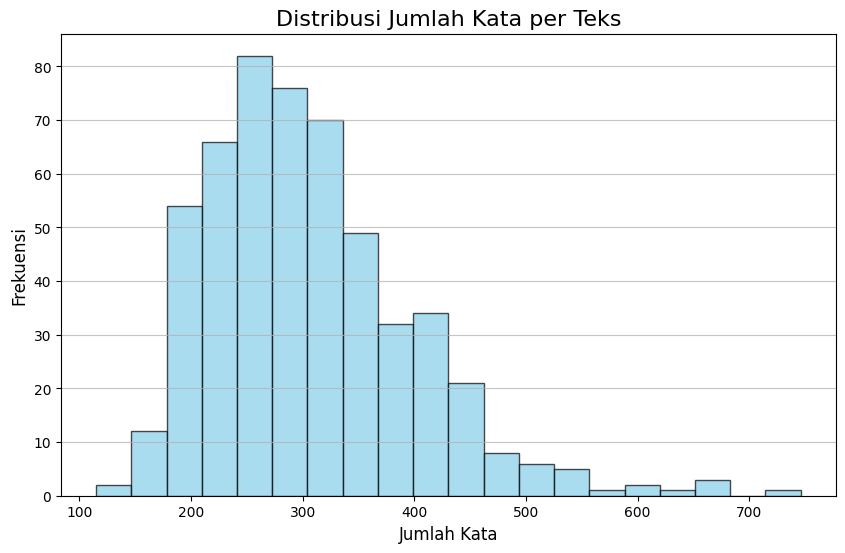

In [10]:
# Tambahkan kolom jumlah kata
df['Word_Count'] = df['Teks'].apply(lambda x: len(x.split()))

# Statistik deskriptif jumlah kata
word_count_stats = df['Word_Count'].describe()
print("Statistik Jumlah Kata:")
print(word_count_stats)
print("")

# Barchart distribusi jumlah kata
plt.figure(figsize=(10, 6))
df['Word_Count'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribusi Jumlah Kata per Teks', fontsize=16)
plt.xlabel('Jumlah Kata', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

stats = {
    'Mean': word_count_stats['mean'],
    'Median': word_count_stats['50%'],
    'Min': word_count_stats['min'],
    'Max': word_count_stats['max']
}

Berdasarkan distribusi jumlah kata dan statistik deskriptif, data hasil scraping terlihat cukup konsisten dan sesuai dengan konten berita.

- **Jumlah kata rata-rata** adalah 305, dengan median 293, yang menunjukkan distribusi cukup seimbang.
- **Rentang jumlah kata** dari 115 hingga 746 kata menunjukkan variasi panjang teks yang wajar untuk artikel berita.
- Grafik histogram memperlihatkan distribusi yang mendekati normal, dengan mayoritas artikel memiliki jumlah kata antara 200-400.

Hasil ini menunjukkan bahwa data scraping berhasil mendapatkan teks berita yang utuh dan relevan, tanpa teks yang terlalu pendek (indikasi scraping gagal) atau terlalu panjang.

### Word Frequency

In [11]:
all_text = ' '.join(df['Lemmatized']) # Menggabungkan semua teks dalam kolom 'Lemmatized' menjadi satu string
all_words = all_text.split() # Tokenisasi semua kata dalam teks
word_freq = Counter(all_words) # Hitung frekuensi kata

freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
freq_df.head(50)

,Word,Frequency
45,main,1608
95,jakarta,869
242,vs,832
27,menang,780
75,tim,765
21,gol,725
68,indonesia,708
20,laga,681
12,tanding,629
71,latih,593


`jakarta` dan `advertisement` adalah contoh kata-kata yang tidak relevan karena hasil dari proses scraping yang tidak sengaja mengambil elemen tambahan dari situs web, seperti lokasi penerbitan berita atau bagian iklan yang biasanya muncul di halaman web. Kata-kata ini tidak memiliki kontribusi signifikan untuk analisis teks yang kita lakukan dan sebaiknya dihapus agar hasil analisis lebih akurat.

In [12]:
# Fungsi untuk menghitung jumlah kata yang mengandung substring tertentu
def count_words_with_substring(df, column, substring):
    all_text = ' '.join(df[column])                                    # Menggabungkan semua teks dalam kolom menjadi satu string
    all_words = all_text.split()                                       # Tokenisasi semua kata dalam teks
    filtered_words = [word for word in all_words if substring in word] # Filter kata-kata yang mengandung substring
    return len(filtered_words), set(filtered_words)                    # Hitung jumlah kata dan kembalikan hasilnya

# Hitung untuk kata 'liputan'
count_liputan, words_liputan = count_words_with_substring(df, 'Lemmatized', 'liputan')
print(f"Jumlah kata yang mengandung 'liputan': {count_liputan}")
print(f"Kata-kata tersebut: {words_liputan}")

# Hitung untuk kata 'detik'
count_detik, words_detik = count_words_with_substring(df, 'Lemmatized', 'detik')
print(f"Jumlah kata yang mengandung 'detik': {count_detik}")
print(f"Kata-kata tersebut: {words_detik}")

# Hitung untuk kata 'antara'
count_antara, words_antara = count_words_with_substring(df, 'Lemmatized', 'antara')
print(f"Jumlah kata yang mengandung 'antara': {count_antara}")
print(f"Kata-kata tersebut: {words_antara}")

Jumlah kata yang mengandung 'liputan': 211
Kata-kata tersebut: {'liputancom'}
Jumlah kata yang mengandung 'detik': 63
Kata-kata tersebut: {'detikjateng', 'detiksport', 'detikevent', 'detikdetik', 'detik', 'detikjabar', 'detikjogja'}
Jumlah kata yang mengandung 'antara': 14
Kata-kata tersebut: {'antara', 'goantara', 'nusantara', 'dirgantara', 'rifiantara'}


Kata-kata seperti `liputancom`, `detiksport`, `detikjabar`, `detikjogja`, `detikevent`, `detikjateng`, dan `antara` adalah bagian dari elemen web berita yang ikut terscraping, seperti nama situs atau subdomain. Kata-kata ini tidak relevan untuk analisis dan sebaiknya dihapus agar hasil lebih fokus pada konten berita.

In [13]:
# Daftar kata yang ingin dihapus
unwanted_words = {'jakarta', 'advertisement', 'liputancom', 'detiksport', 'detikjabar',
                  'detikjogja', 'detikevent', 'detikjateng', 'antara'}

def remove_unwanted_words(text):
    words = text.split()  # Tokenisasi teks
    filtered_words = [word for word in words if word not in unwanted_words]  # Hapus kata tidak relevan
    return ' '.join(filtered_words)  # Gabungkan kembali kata-kata menjadi teks

df['Final'] = df['Lemmatized'].apply(remove_unwanted_words)
df[['Lemmatized', 'Final']].head(10)

,Lemmatized,Final
0,persib bandung telan kalah liga soccer brain a...,persib bandung telan kalah liga soccer brain a...
1,liputancom jakarta latih timnas indonesia patr...,latih timnas indonesia patrick kluivert tegas ...
2,barcelona juara piala super spanyol tinggal du...,barcelona juara piala super spanyol tinggal du...
3,pss sleman tren positif super elang jawa ungka...,pss sleman tren positif super elang jawa ungka...
4,persib bandung gagal raih poin lawan dewa unit...,persib bandung gagal raih poin lawan dewa unit...
5,liputancom jakarta latih timnas indonesia patr...,latih timnas indonesia patrick kluivert ungkap...
6,barito putera amuk kandang madura united menit...,barito putera amuk kandang madura united menit...
7,jakarta latih sita tangerang fabio lefundes ma...,latih sita tangerang fabio lefundes main kondi...
8,dewa united malu persib bandung lanjut liga me...,dewa united malu persib bandung lanjut liga me...
9,malut united persebaya surabaya pekan liga las...,malut united persebaya surabaya pekan liga las...


### Word Cloud

In [14]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

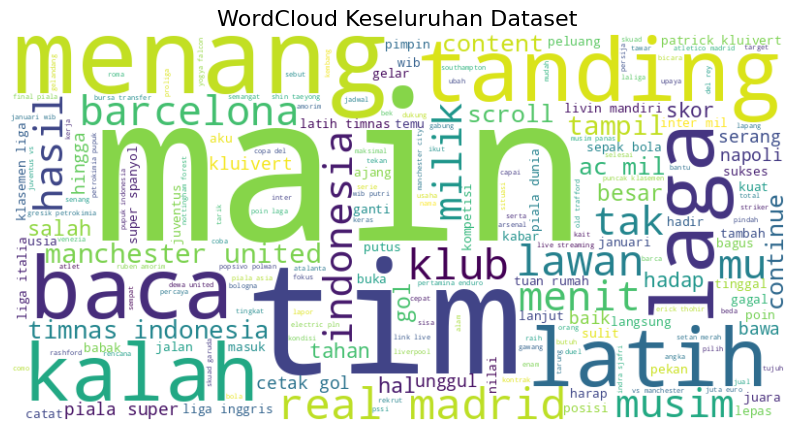

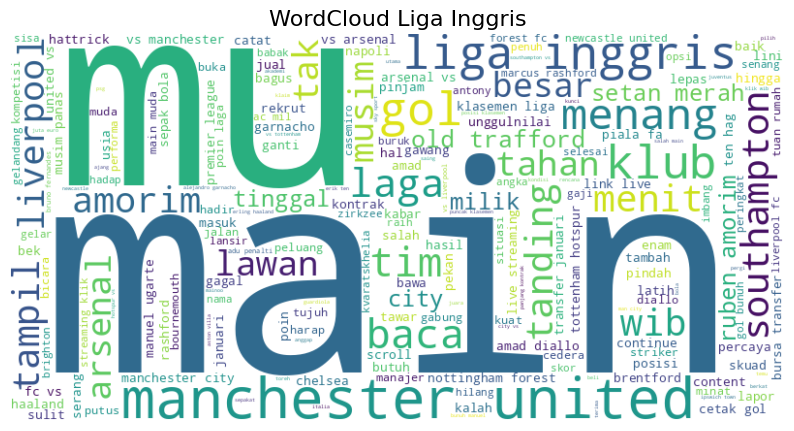

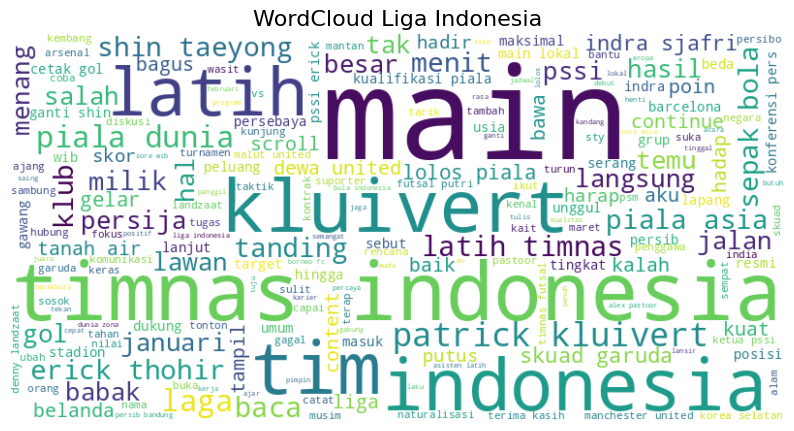

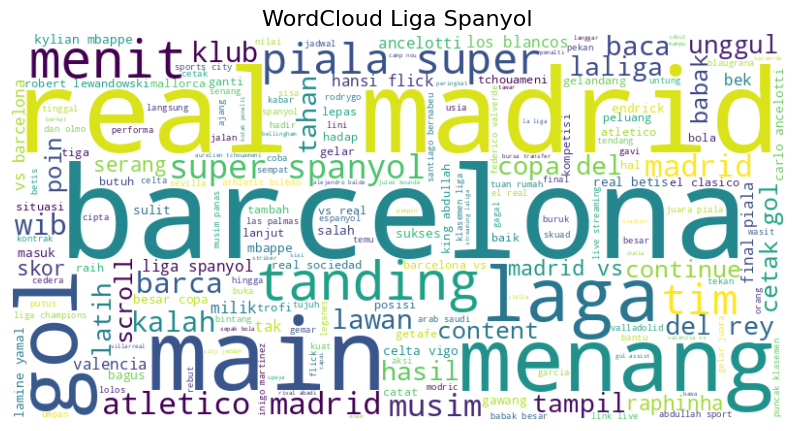

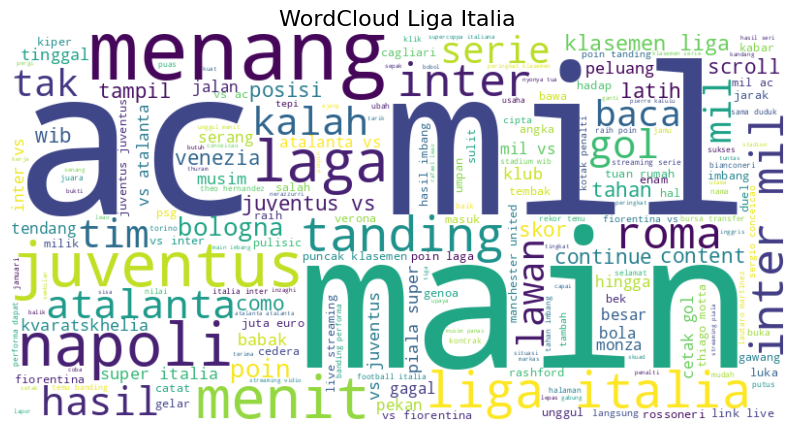

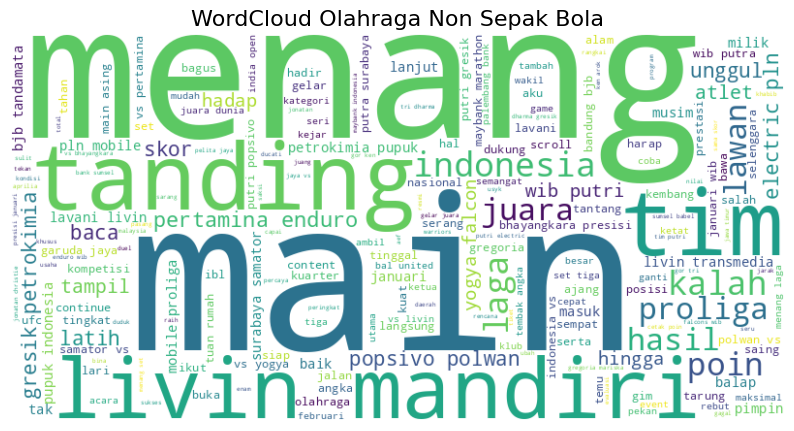

In [15]:
# Gabungkan teks untuk keseluruhan dataset
all_text = ' '.join(df['Final'])
generate_wordcloud(all_text, 'WordCloud Keseluruhan Dataset')

# Gabungkan teks untuk masing-masing kategori
categories = ['Liga Inggris', 'Liga Indonesia', 'Liga Spanyol', 'Liga Italia', 'Olahraga Non Sepak Bola']

for category in categories:
    category_text = ' '.join(df[df['Label'] == category]['Final'])
    generate_wordcloud(category_text, f'WordCloud {category}')

Dari WordCloud yang dibuat, berikut beberapa insight yang bisa diperoleh:

1. **Keseluruhan Dataset**:
   - Kata-kata seperti "main", "menang", "lawan", dan "tanding" mendominasi. Ini menunjukkan bahwa berita olahraga banyak fokus pada pertandingan dan hasilnya.

2. **Liga Inggris**:
   - "Manchester United" terlihat mendominasi, bersama dengan "Arsenal" dan "gol". Klub besar cenderung menjadi pusat perhatian.

3. **Liga Indonesia**:
   - Kata seperti "timnas", "Indonesia", dan "latih" sering muncul. Berita tentang tim nasional dan pelatih menjadi fokus utama.

4. **Liga Spanyol**:
   - "Barcelona", "Real Madrid", dan "menang" adalah kata utama. Hal ini wajar karena persaingan kedua klub ini sering menjadi topik utama.

5. **Liga Italia**:
   - "AC Milan", "Juventus", dan "Napoli" mendominasi. Persaingan di Serie A menjadi topik utama berita.

6. **Olahraga Non Sepak Bola**:
   - Kata seperti "tim", "menang", dan "tanding" tetap dominan, tapi ada juga kata unik seperti "proliga", "pupuk", dan "pertamina" yang menunjukkan fokus pada olahraga lain seperti voli dan sponsor lokal.

Secara umum, WordCloud memberikan gambaran bahwa berita sangat fokus pada pertandingan, hasil, dan tim yang sedang populer. Kata-kata spesifik kategori juga memberikan konteks yang jelas untuk masing-masing liga atau jenis olahraga

## Data Splitting

In [16]:
save_path = "/content/drive/My Drive/UAS TM/Dataset_Final2.csv"
df.to_csv(save_path, index=False, encoding="utf-8")

In [30]:
df = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_Final2.csv")

In [31]:
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Label'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Label'])

print(f"Training set: {len(train_data)} entries")
print(f"Validation set: {len(val_data)} entries")
print(f"Testing set: {len(test_data)} entries")

Training set: 367 entries
Validation set: 79 entries
Testing set: 79 entries


Pembagian dataset ini jadi 70% buat training, 15% buat validasi, dan 15% buat testing biar model bisa belajar dengan cukup data, terus diuji dan divalidasi dengan data yang belum pernah dilihat sebelumnya. Stratified sampling dipakai supaya proporsi label di setiap bagian tetap seimbang, jadi hasil modelnya ngga berat sebelah.

In [5]:
train_data['Label'].value_counts()

,count
Label,
Liga Indonesia,82
Olahraga Non Sepak Bola,75
Liga Inggris,73
Liga Italia,69
Liga Spanyol,68


In [6]:
test_data['Label'].value_counts()

,count
Label,
Liga Indonesia,18
Olahraga Non Sepak Bola,16
Liga Inggris,16
Liga Italia,15
Liga Spanyol,14


In [7]:
val_data['Label'].value_counts()

,count
Label,
Liga Indonesia,17
Olahraga Non Sepak Bola,16
Liga Inggris,16
Liga Italia,15
Liga Spanyol,15


# Classification Model (LLM)

## LLM One Stage

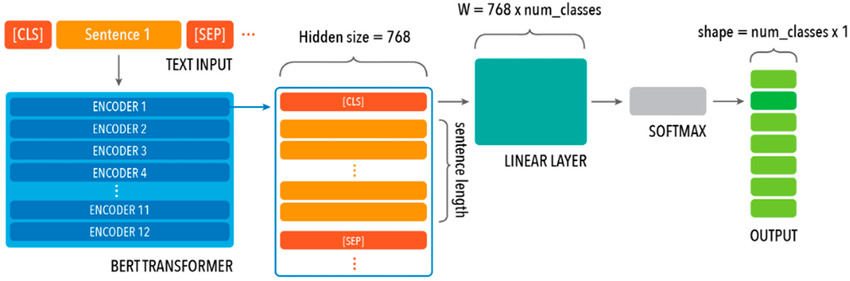

source: https://www.researchgate.net/publication/374608193_Applying_Natural_Language_Processing_to_Single-Report_Prediction_of_Metastatic_Disease_Response_Using_the_OR-RADS_Lexicon

BERT (Bidirectional Encoder Representations from Transformers) adalah model NLP yang dikembangkan oleh Google AI.
BERT membaca teks secara bidirectional (dua arah), sehingga lebih baik dalam memahami konteks kata dibandingkan model satu arah.
Model `bert-base-uncased` adalah varian BERT yang berukuran "base" dengan 12 lapisan encoder, 768 dimensi hidden layer, dan 12 attention heads.
Model ini tidak membedakan huruf besar dan kecil (uncased) dan telah dilatih menggunakan dataset besar seperti Wikipedia dan BookCorpus.

**Cara Kerja `bert-base-uncased` pada Tugas Klasifikasi**
1. **Input Teks**:
   - Model menerima input berupa teks mentah.
   - Teks diubah menjadi token menggunakan **tokenizer BERT**, yang mencakup:
     - **[CLS]**: Token khusus di awal teks yang mewakili keseluruhan kalimat atau teks, digunakan untuk tugas klasifikasi.
     - **[SEP]**: Token pemisah yang digunakan jika ada lebih dari satu kalimat dalam input.
     - Tokenisasi ini juga mencakup pemecahan kata menjadi sub-kata jika kata tersebut tidak ada di kosa kata model.

2. **Lapisan Encoder (BERT Transformer)**:
   - Input token melewati **12 lapisan encoder** berbasis mekanisme **self-attention**.
   - **Self-attention** memungkinkan model memahami hubungan antar kata secara bidirectional (dua arah), sehingga setiap kata dapat dipahami berdasarkan konteks kata-kata sebelumnya dan sesudahnya.
   - Setiap lapisan encoder menghasilkan representasi yang lebih kaya untuk setiap token.

3. **Hidden Representation**:
   - Setelah melewati semua lapisan encoder, setiap token direpresentasikan sebagai vektor berdimensi **768**.
   - Representasi dari token **[CLS]** diambil sebagai ringkasan dari keseluruhan teks dan digunakan untuk tugas klasifikasi.

4. **Linear Layer dan Softmax**:
   - Representasi **[CLS]** dilewatkan ke **Linear Layer** (lapisan dense) untuk menghasilkan skor logit untuk setiap kelas.
   - **Softmax** kemudian mengubah skor logit ini menjadi probabilitas untuk setiap kelas.

5. **Output (Klasifikasi Akhir)**:
   - Probabilitas tertinggi dari fungsi Softmax menentukan label kelas akhir.
   - Jika model ini digunakan untuk 5 label, maka hasil akhir adalah satu dari lima kelas tersebut, berdasarkan probabilitas tertinggi.

Model ini cocok untuk berbagai tugas NLP seperti klasifikasi teks, analisis sentimen, dan ekstraksi informasi.
Pretrained pada dataset besar, BERT hanya memerlukan fine-tuning pada dataset spesifik untuk performa optimal.

### Label Mapping

In [5]:
label_mapping = {
    "Liga Inggris": 0,
    "Liga Indonesia": 1,
    "Liga Spanyol": 2,
    "Liga Italia": 3,
    "Olahraga Non Sepak Bola": 4
}

train_data['Label'] = train_data['Label'].map(label_mapping)
val_data['Label'] = val_data['Label'].map(label_mapping)
test_data['Label'] = test_data['Label'].map(label_mapping)

Mapping kolom label menjadi numerik diperlukan karena model machine learning, seperti BERT, hanya bisa memahami data dalam bentuk angka, bukan string. Dengan mapping, label teks diubah ke format numerik yang dapat diproses oleh model saat pelatihan dan prediksi.

### Tokenize Data

In [6]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
def tokenize_data(examples):
    return tokenizer(examples['Final'], padding="max_length", truncation=True)

Fungsi tokenize_data menggunakan tokenizer BERT untuk mengubah teks di kolom Final menjadi token numerik, dengan padding agar panjangnya seragam dan truncation untuk memotong teks yang terlalu panjang.

In [8]:
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

Dataset training, validation, dan testing (train_data, val_data, test_data) dari pandas DataFrame diubah menjadi format Hugging Face Dataset agar kompatibel dengan model.

In [9]:
train_dataset = train_dataset.map(tokenize_data, batched=True)
val_dataset = val_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Tokenisasi diterapkan ke setiap dataset (train, val, test) menggunakan map, sehingga setiap baris teks diubah menjadi token numerik bersama dengan input_ids dan attention_mask.

In [10]:
train_dataset = train_dataset.rename_column("Label", "labels")
val_dataset = val_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")

Kolom Label diubah menjadi labels karena model Hugging Face membutuhkan kolom ini untuk klasifikasi.

In [11]:
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Dataset diformat ke PyTorch dengan kolom penting (input_ids, attention_mask, labels) untuk siap digunakan dalam pelatihan model.

### Define Pretrained Model + Hyperparameter Tuning

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model pretrained BERT disesuaikan untuk tugas klasifikasi 5 label dengan menambahkan lapisan klasifikasi.

In [13]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Direktori output
    evaluation_strategy="epoch",      # Evaluasi di setiap epoch
    save_strategy="epoch",            # Simpan model terbaik setiap epoch
    logging_dir="./logs",             # Direktori logging
    learning_rate=3e-5,               # Hyperparameter tuning (learning rate)
    per_device_train_batch_size=16,   # Hyperparameter tuning (batch size)
    per_device_eval_batch_size=16,
    num_train_epochs=10,              # Jumlah epoch
    weight_decay=0.01,                # Regularisasi
    logging_steps=10,                 # Frekuensi logging
    load_best_model_at_end=True,      # Simpan model terbaik
    metric_for_best_model="accuracy", # Metrik evaluasi terbaik
    report_to="none"                  # Nonaktifkan logging ke wandb
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


| **Parameter**           | **Default** | **Tuning Anda** | **Perubahan**                          |
|--------------------------|-------------|------------------|----------------------------------------|
| `learning_rate`          | `5e-5`      | `3e-5`           | Membuat training lebih stabil.         |
| `per_device_train_batch_size` | `8`       | `16`             | Mempercepat training dengan lebih banyak data per batch. |
| `num_train_epochs`       | `3`         | `10`             | Meningkatkan jumlah epoch untuk memberikan waktu pembelajaran lebih lama. |
| `weight_decay`           | `0.0`       | `0.01`           | Menambahkan regularisasi untuk mengurangi overfitting. |

---

**Hyperparameter Tuning**
1. **`learning_rate=3e-5`**:
   - **Fungsinya**: Mengontrol seberapa besar perubahan bobot model pada setiap langkah optimasi.
   - **Yang diubah**:
     - Default **learning rate** pada Hugging Face adalah `5e-5`.
     - Menurunkannya menjadi `3e-5` untuk memastikan training lebih stabil dan menghindari overshooting (lonjakan loss karena langkah terlalu besar).
     - Nilai yang terlalu besar dapat menyebabkan model gagal konvergen, sedangkan nilai terlalu kecil membuat pelatihan lambat.

2. **`per_device_train_batch_size=16`**:
   - **Fungsinya**: Menentukan jumlah sampel data yang diproses sekaligus dalam satu batch pada setiap perangkat (GPU/CPU).
   - **Yang diubah**:
     - Default batch size di Hugging Face biasanya adalah **8**.
     - Menaikkannya menjadi **16**, yang berarti model belajar lebih cepat karena lebih banyak data diproses dalam satu iterasi.
     - Batch size yang lebih besar meningkatkan stabilitas pembelajaran, tetapi memerlukan lebih banyak memori GPU.

3. **`num_train_epochs=10`**:
   - **Fungsinya**: Menentukan berapa kali model melihat seluruh dataset selama pelatihan.
   - **Yang diubah**:
     - Default jumlah epoch adalah **3**.
     - Menaikkannya menjadi **10**, yang memungkinkan model untuk mempelajari pola dari dataset secara lebih mendalam.
     - Menambahkan jumlah epoch dapat meningkatkan performa jika model underfitting (belum belajar cukup dari data). Namun, berhati-hatilah dengan risiko overfitting jika jumlah epoch terlalu besar.

4. **`weight_decay=0.01`**:
   - **Fungsinya**: Menambahkan regularisasi untuk mengurangi overfitting dengan memberikan penalti pada bobot besar.
   - **Yang diubah**:
     - Default weight decay adalah **0.0** (tidak ada regularisasi).
     - Menambahkannya menjadi **0.01** untuk membantu model menggeneralisasi lebih baik pada dataset baru.

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1_score": f1_score(labels, predictions, average="weighted"),
    }

Untuk menghitung metrik seperti accuracy, precision, recall, dan F1-score dari hasil prediksi

### Training

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Dataset training digunakan untuk memperbarui bobot model
    eval_dataset=val_dataset,    # Dataset validasi digunakan untuk evaluasi performa
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-15-0dacb211e69c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Mengatur pipeline pelatihan dengan dataset, parameter pelatihan (training_args), dan fungsi evaluasi (compute_metrics). Selain itu, model pretrained dilatih ulang menggunakan dataset Anda untuk menyesuaikan bobot pada encoder dan lapisan klasifikasi baru.

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,1.292000,1.015019,0.784810,0.821192,0.784810,0.777978
2,0.770200,0.490963,0.911392,0.923384,0.911392,0.912643
3,0.448200,0.338585,0.936709,0.943519,0.936709,0.936677
4,0.274000,0.190059,0.949367,0.955363,0.949367,0.949872
5,0.158400,0.150327,0.962025,0.965583,0.962025,0.961952
6,0.056500,0.223035,0.924051,0.932267,0.924051,0.924764
7,0.053300,0.137674,0.974684,0.975428,0.974684,0.974671
8,0.080800,0.098232,0.974684,0.975428,0.974684,0.974671
9,0.083400,0.088622,0.974684,0.975428,0.974684,0.974671
10,0.026500,0.092005,0.974684,0.975428,0.974684,0.974671


TrainOutput(global_step=230, training_loss=0.326067648374516, metrics={'train_runtime': 471.7386, 'train_samples_per_second': 7.78, 'train_steps_per_second': 0.488, 'total_flos': 965643582842880.0, 'train_loss': 0.326067648374516, 'epoch': 10.0})

### Evaluation

In [17]:
# Daftar label berdasarkan mapping
label_names = ["Liga Inggris", "Liga Indonesia", "Liga Spanyol", "Liga Italia", "Olahraga Non Sepak Bola"]

# Fungsi evaluasi
def evaluate_model(trainer, dataset, dataset_name="Testing"):
    # Prediksi dataset
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    preds = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Hitung metrik
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='weighted')
    rec = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    # Print metrik
    print(f"=== {dataset_name} Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1}

=== Training Metrics ===
Accuracy: 0.9891
Precision: 0.9894
Recall: 0.9891
F1-Score: 0.9891


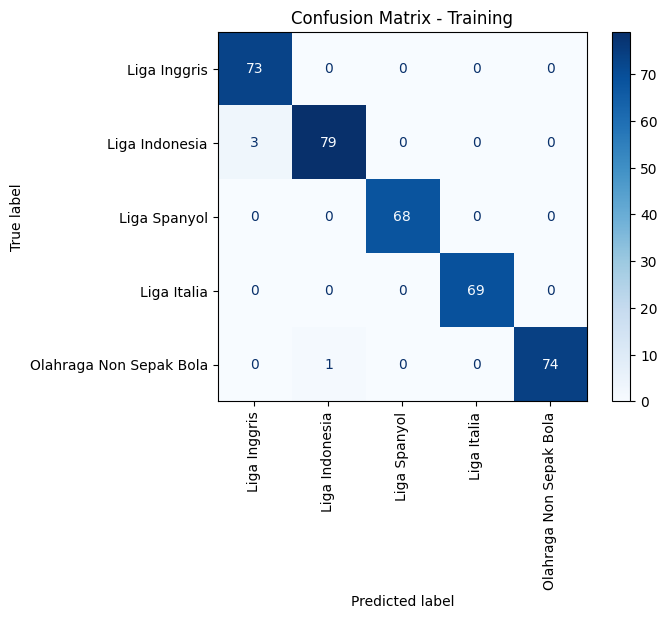

In [18]:
train_results = evaluate_model(trainer, train_dataset, "Training")

=== Validation Metrics ===
Accuracy: 0.9747
Precision: 0.9754
Recall: 0.9747
F1-Score: 0.9747


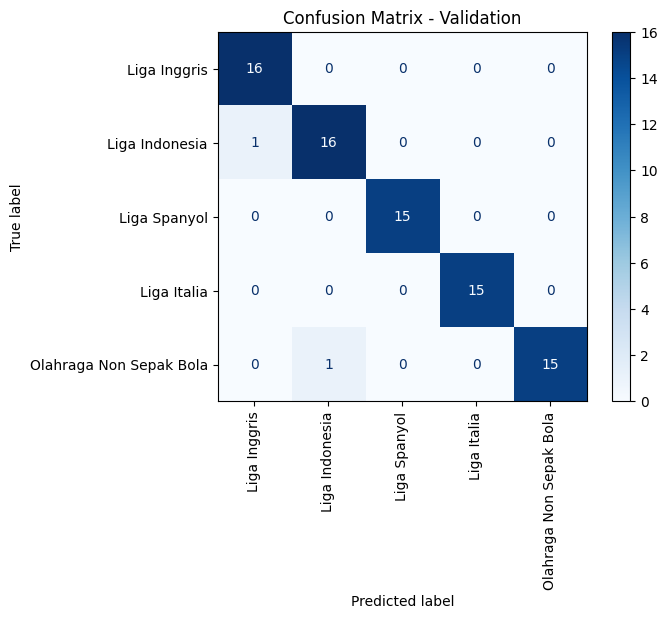

In [19]:
val_results = evaluate_model(trainer, val_dataset, "Validation")

=== Testing Metrics ===
Accuracy: 0.9241
Precision: 0.9308
Recall: 0.9241
F1-Score: 0.9257


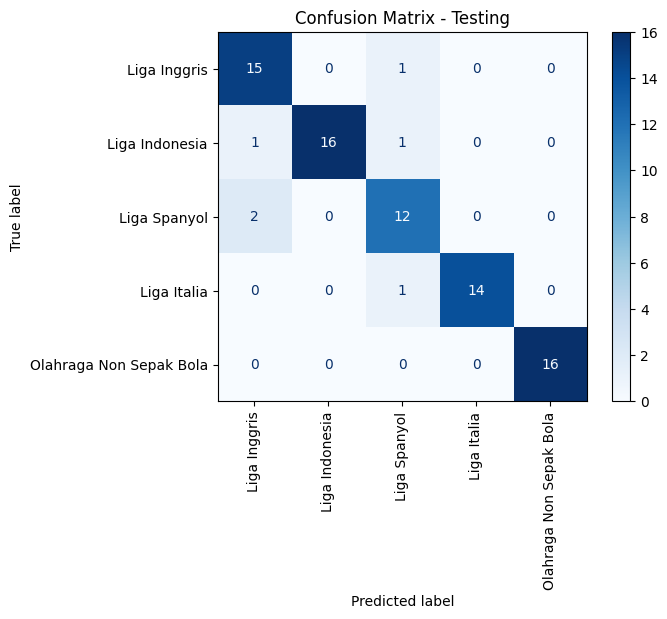

In [20]:
test_results = evaluate_model(trainer, test_dataset, "Testing")

## LLM Two Stages

## Stage 1:

### Label Mapping

In [32]:
stage1_mapping = {
    "Liga Inggris": 0,
    "Liga Indonesia": 0,
    "Liga Spanyol": 0,
    "Liga Italia": 0,
    "Olahraga Non Sepak Bola": 1
}

train_data_stage1 = train_data.copy()
val_data_stage1 = val_data.copy()
test_data_stage1 = test_data.copy()

train_data_stage1['Label'] = train_data_stage1['Label'].map(stage1_mapping)
val_data_stage1['Label'] = val_data_stage1['Label'].map(stage1_mapping)
test_data_stage1['Label'] = test_data_stage1['Label'].map(stage1_mapping)

Lakukan **mapping label** supaya data jadi dua kelas aja: **Sepak Bola (0)** dan **Non Sepak Bola (1)**. Jadi, berita dari Liga Inggris, Indonesia, Spanyol, dan Italia semua dianggap "Sepak Bola", sedangkan berita "Olahraga Non Sepak Bola" jadi kelas lain. Setelah mapping, data training, validasi, dan testing diubah sesuai klasifikasi baru ini. Simpelnya, ini biar model tahu mana berita bola dan mana yang bukan.

### Tokenize Data

In [33]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_data(examples):
    return tokenizer(examples['Final'], padding="max_length", truncation=True)

# Tokenisasi
train_dataset_stage1 = Dataset.from_pandas(train_data_stage1).map(tokenize_data, batched=True)
val_dataset_stage1 = Dataset.from_pandas(val_data_stage1).map(tokenize_data, batched=True)
test_dataset_stage1 = Dataset.from_pandas(test_data_stage1).map(tokenize_data, batched=True)

# Ubah nama kolom Label menjadi labels
train_dataset_stage1 = train_dataset_stage1.rename_column("Label", "labels")
val_dataset_stage1 = val_dataset_stage1.rename_column("Label", "labels")
test_dataset_stage1 = test_dataset_stage1.rename_column("Label", "labels")

# Format dataset ke PyTorch
train_dataset_stage1.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset_stage1.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_stage1.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Selanjutnya lakukan **tokenisasi data** agar teks diubah jadi format angka yang bisa dimengerti model. Pertama, pakai tokenizer dari pretrained **BERT** untuk memecah teks (kolom `Final`) jadi token, dengan panjang maksimum yang diatur otomatis. Lalu, nama kolom `Label` diganti jadi `labels` supaya sesuai format model. Terakhir, dataset diubah jadi format **PyTorch** dengan tiga kolom penting: `input_ids`, `attention_mask`, dan `labels`, biar siap digunakan untuk training model.

### Define Pretrained Model + Hyperparameter Tuning

In [34]:
model_stage1 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

training_args_stage1 = TrainingArguments(
    output_dir="./results_stage1",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Lanjutkan dengan membuat **model Stage 1** menggunakan pretrained **BERT** dengan 2 kelas output (Sepak Bola dan Non Sepak Bola). Training arguments diatur untuk training, termasuk learning rate, batch size, jumlah epoch, regularisasi, dan evaluasi otomatis di setiap epoch, dengan menyimpan model terbaik berdasarkan akurasi.

### Training

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1_score": f1_score(labels, predictions, average="weighted"),
    }

Untuk menghitung metrik seperti accuracy, precision, recall, dan F1-score dari hasil prediksi

In [36]:
trainer_stage1 = Trainer(
    model=model_stage1,
    args=training_args_stage1,
    train_dataset=train_dataset_stage1,
    eval_dataset=val_dataset_stage1,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop jika tidak ada peningkatan selama 3 epoch
)

<ipython-input-36-44596ab9a60a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage1 = Trainer(


In [37]:
trainer_stage1.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.317200,0.314798,0.886076,0.900316,0.886076,0.867584
2,0.071100,0.223520,0.949367,0.952390,0.949367,0.946529
3,0.107500,0.008538,1.000000,1.000000,1.000000,1.000000
4,0.042500,0.084758,0.962025,0.963751,0.962025,0.960503
5,0.078100,0.030220,0.987342,0.988086,0.987342,0.987483
6,0.012500,0.130565,0.974684,0.975463,0.974684,0.974037


TrainOutput(global_step=138, training_loss=0.1255456960449616, metrics={'train_runtime': 388.1278, 'train_samples_per_second': 9.456, 'train_steps_per_second': 0.593, 'total_flos': 579370543902720.0, 'train_loss': 0.1255456960449616, 'epoch': 6.0})

### Evaluation

In [38]:
def evaluate_model(trainer, dataset, dataset_name="Testing"):
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    preds = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Hitung metrik
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")
    rec = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")

    # Print metrik
    print(f"=== {dataset_name} Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sepak Bola", "Non Sepak Bola"])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1}

=== Training Stage 1 Metrics ===
Accuracy: 0.9864
Precision: 0.9865
Recall: 0.9864
F1-Score: 0.9864


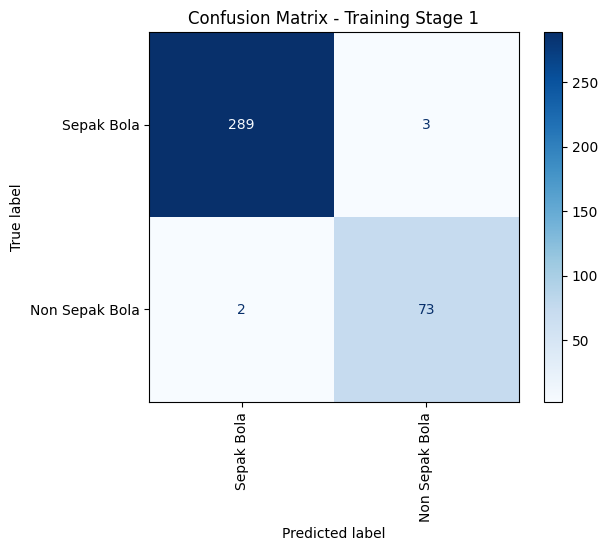

In [39]:
train_results_stage1 = evaluate_model(trainer_stage1, train_dataset_stage1, "Training Stage 1")

=== Validation Stage 1 Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


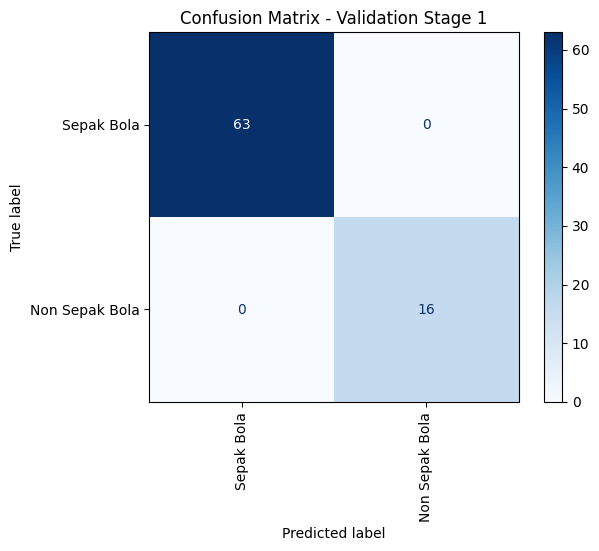

In [40]:
val_results_stage1 = evaluate_model(trainer_stage1, val_dataset_stage1, "Validation Stage 1")

=== Testing Stage 1 Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


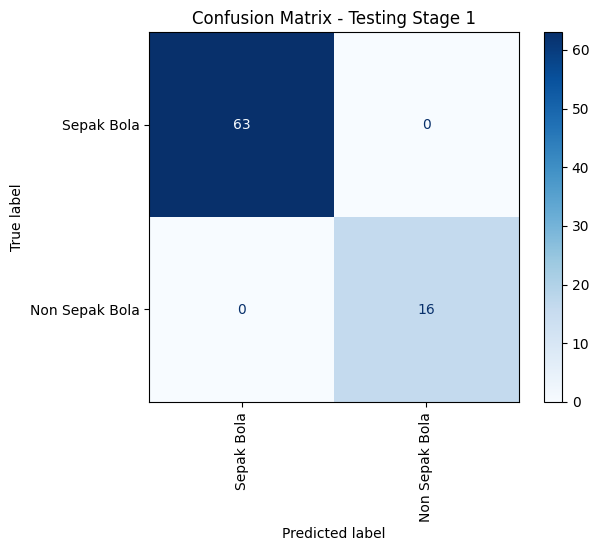

In [41]:
test_results_stage1 = evaluate_model(trainer_stage1, test_dataset_stage1, "Testing Stage 1")

In [42]:
# Prediksi data testing Stage 1
predictions_stage1 = trainer_stage1.predict(test_dataset_stage1)
logits_stage1 = predictions_stage1.predictions
labels_stage1 = predictions_stage1.label_ids
preds_stage1 = torch.argmax(torch.tensor(logits_stage1), dim=-1).numpy()

# Tambahkan hasil prediksi ke dataset testing asli
test_data_stage1_results = test_data.copy()
test_data_stage1_results['Predicted_Label'] = preds_stage1  # Tambahkan kolom hasil prediksi

save_path = "/content/drive/My Drive/UAS TM/Dataset_Testing_Stage1.csv"
test_data_stage1_results.to_csv(save_path, index=False, encoding="utf-8")

Simpan hasil prediksi dari **Stage 1** ke dataset testing asli, terus tambahin kolom baru yang namanya `Predicted_Label` buat nunjukin label hasil prediksi. Setelah itu, datasetnya disimpen ke file CSV biar gampang dipake lagi tanpa harus nge-run ulang prediksi Stage 1.

In [49]:
test_data_stage1_results[['Final', 'Label', 'Predicted_Label']].head(10)

,Final,Label,Predicted_Label
0,latih atalanta gian piero gasperini sebut skua...,Liga Italia,0
1,manchester united hasil aman poin lanjut liga ...,Liga Inggris,0
2,kabar kejut alphonso davies disebutsebut labuh...,Liga Spanyol,0
3,napoli lebar jarak poin kejar inter mil atalan...,Liga Italia,0
4,salah siap timnas indonesia jelang piala asia ...,Liga Indonesia,0
5,manajer persija bambang pamungkas aku tim komu...,Liga Indonesia,0
6,inter mil gagal aman unggul puas imbang bologn...,Liga Italia,0
7,manchester united bala bantu klub serie ac mil...,Liga Inggris,0
8,exhibition taekwondo kyorugi poomsae tajuk pro...,Olahraga Non Sepak Bola,1
9,inter mil hasil bungkam lawan como laga pekan ...,Liga Italia,0


Load Dataset

In [53]:
# Load dataset hasil prediksi Stage 1
test_data_stage1_results = pd.read_csv("/content/drive/My Drive/UAS TM/Dataset_Testing_Stage1.csv")

# Filter data yang terprediksi sebagai Sepak Bola (label 0)
test_data_stage2_input = test_data_stage1_results[test_data_stage1_results['Predicted_Label'] == 0].copy()
test_data_stage2_input[['Final', 'Label', 'Predicted_Label']].head(10)

,Final,Label,Predicted_Label
0,latih atalanta gian piero gasperini sebut skua...,Liga Italia,0
1,manchester united hasil aman poin lanjut liga ...,Liga Inggris,0
2,kabar kejut alphonso davies disebutsebut labuh...,Liga Spanyol,0
3,napoli lebar jarak poin kejar inter mil atalan...,Liga Italia,0
4,salah siap timnas indonesia jelang piala asia ...,Liga Indonesia,0
5,manajer persija bambang pamungkas aku tim komu...,Liga Indonesia,0
6,inter mil gagal aman unggul puas imbang bologn...,Liga Italia,0
7,manchester united bala bantu klub serie ac mil...,Liga Inggris,0
9,inter mil hasil bungkam lawan como laga pekan ...,Liga Italia,0
10,as roma selamat kalah lawat markas bologna pen...,Liga Italia,0


**Load dataset hasil prediksi Stage 1** dari file CSV, terus filter data yang diprediksi sebagai **Sepak Bola (label 0)**. Karena data ini yang akan digunakan pada stage 2 nanti untuk dataset testing nya.

## Stage 2:

### Label Mapping

In [54]:
# Filter data training dan validasi hanya untuk Sepak Bola
train_data_stage2 = train_data[train_data['Label'].isin(["Liga Inggris", "Liga Indonesia", "Liga Spanyol", "Liga Italia"])].copy()
val_data_stage2 = val_data[val_data['Label'].isin(["Liga Inggris", "Liga Indonesia", "Liga Spanyol", "Liga Italia"])].copy()

stage2_mapping = {
    "Liga Inggris": 0,
    "Liga Indonesia": 1,
    "Liga Spanyol": 2,
    "Liga Italia": 3
}

train_data_stage2['Label'] = train_data_stage2['Label'].map(stage2_mapping)
val_data_stage2['Label'] = val_data_stage2['Label'].map(stage2_mapping)
test_data_stage2_input['Label'] = test_data_stage2_input['Label'].map(stage2_mapping)

Filter data training dan validasi supaya hanya menyertakan berita Sepak Bola (Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia). Setelah itu, labelnya diubah (mapping) menjadi angka. Proses ini memastikan semua dataset (training, validasi, dan testing) di Stage 2 sudah siap digunakan dengan label angka.

### Tokenize Data

In [55]:
def tokenize_data(examples):
    return tokenizer(examples['Final'], padding="max_length", truncation=True)

# Tokenisasi
train_dataset_stage2 = Dataset.from_pandas(train_data_stage2).map(tokenize_data, batched=True)
val_dataset_stage2 = Dataset.from_pandas(val_data_stage2).map(tokenize_data, batched=True)
test_dataset_stage2 = Dataset.from_pandas(test_data_stage2_input).map(tokenize_data, batched=True)

# Ubah nama kolom Label menjadi labels
train_dataset_stage2 = train_dataset_stage2.rename_column("Label", "labels")
val_dataset_stage2 = val_dataset_stage2.rename_column("Label", "labels")
test_dataset_stage2 = test_dataset_stage2.rename_column("Label", "labels")

# Format dataset ke PyTorch
train_dataset_stage2.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset_stage2.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_stage2.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/292 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Selanjutnya lakukan **tokenisasi teks** di kolom `Final` jadi format numerik yang bisa diproses model. Kolom `Label` diubah namanya jadi `labels`, dan dataset diformat ke PyTorch dengan tiga kolom utama: `input_ids`, `attention_mask`, dan `labels`, biar siap untuk training dan evaluasi Stage 2.

### Define Pretrained Model + Hyperparameter Tuning

In [58]:
model_stage2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)

training_args_stage2 = TrainingArguments(
    output_dir="./results_stage2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [57]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted"),
        "f1_score": f1_score(labels, predictions, average="weighted"),
    }

### Training

In [59]:
trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=train_dataset_stage2,
    eval_dataset=val_dataset_stage2,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-59-3aa7ad628257>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_stage2 = Trainer(


In [60]:
trainer_stage2.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,1.386100,1.081534,0.539683,0.742022,0.539683,0.477166
2,0.808000,0.432465,0.952381,0.955908,0.952381,0.952181
3,0.384700,0.211630,0.968254,0.971781,0.968254,0.968674
4,0.214600,0.231436,0.920635,0.933333,0.920635,0.921243
5,0.141000,0.164040,0.920635,0.923436,0.920635,0.921597
6,0.066100,0.168285,0.968254,0.971781,0.968254,0.968674


TrainOutput(global_step=114, training_loss=0.46391793562654865, metrics={'train_runtime': 218.2603, 'train_samples_per_second': 13.379, 'train_steps_per_second': 0.871, 'total_flos': 460978846728192.0, 'train_loss': 0.46391793562654865, 'epoch': 6.0})

### Evaluation

In [63]:
def evaluate_model(trainer, dataset, dataset_name="Testing"):
    predictions = trainer.predict(dataset)
    logits = predictions.predictions
    labels = predictions.label_ids
    preds = torch.argmax(torch.tensor(logits), dim=-1).numpy()

    # Hitung metrik
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")
    rec = recall_score(labels, preds, average="weighted")
    f1 = f1_score(labels, preds, average="weighted")

    # Print metrik
    print(f"=== {dataset_name} Metrics ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Liga Inggris", "Liga Indonesia", "Liga Spanyol", "Liga Italia"])
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1_score": f1}

=== Training Stage 2 Metrics ===
Accuracy: 0.9589
Precision: 0.9600
Recall: 0.9589
F1-Score: 0.9590


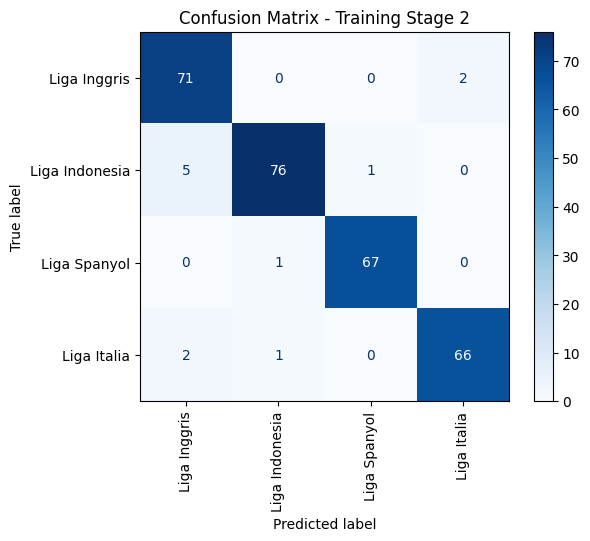

In [64]:
train_results_stage2 = evaluate_model(trainer_stage2, train_dataset_stage2, "Training Stage 2")

=== Validation Stage 2 Metrics ===
Accuracy: 0.9683
Precision: 0.9718
Recall: 0.9683
F1-Score: 0.9687


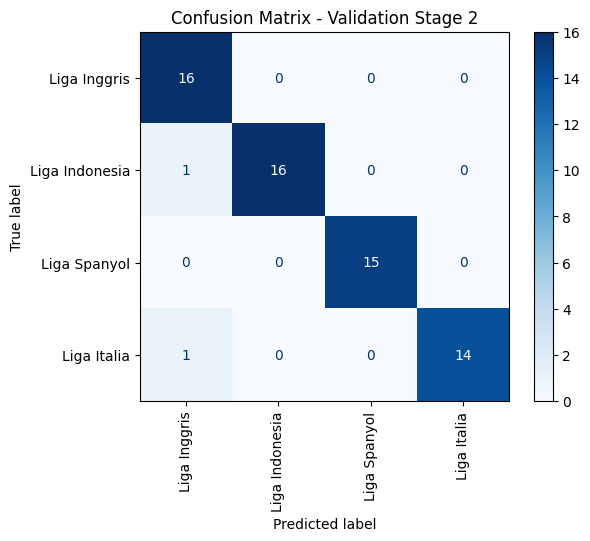

In [67]:
val_results_stage2 = evaluate_model(trainer_stage2, val_dataset_stage2, "Validation Stage 2")

=== Testing Stage 2 Metrics ===
Accuracy: 0.9048
Precision: 0.9132
Recall: 0.9048
F1-Score: 0.9068


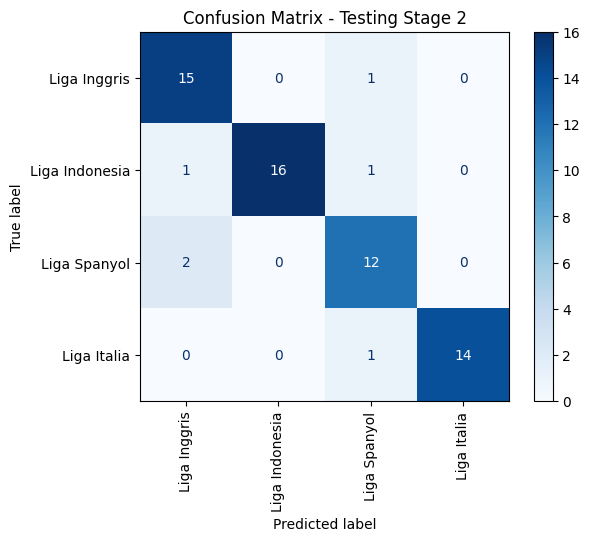

In [68]:
test_results_stage2 = evaluate_model(trainer_stage2, test_dataset_stage2, "Testing Stage 2")

# D. Evaluation

Bandingkan hasil antara model dengan pendekatan 1 stage dan 2 stage. Jelaskan bagaimana anda melakukan evaluasi Paparkan hasil berupa accuracy, precision, recal dan F1 score dari data training, validasi dan testing. Jelaskan informasi apa yang anda peroleh dari perbandingan ini

## Evaluation Metric

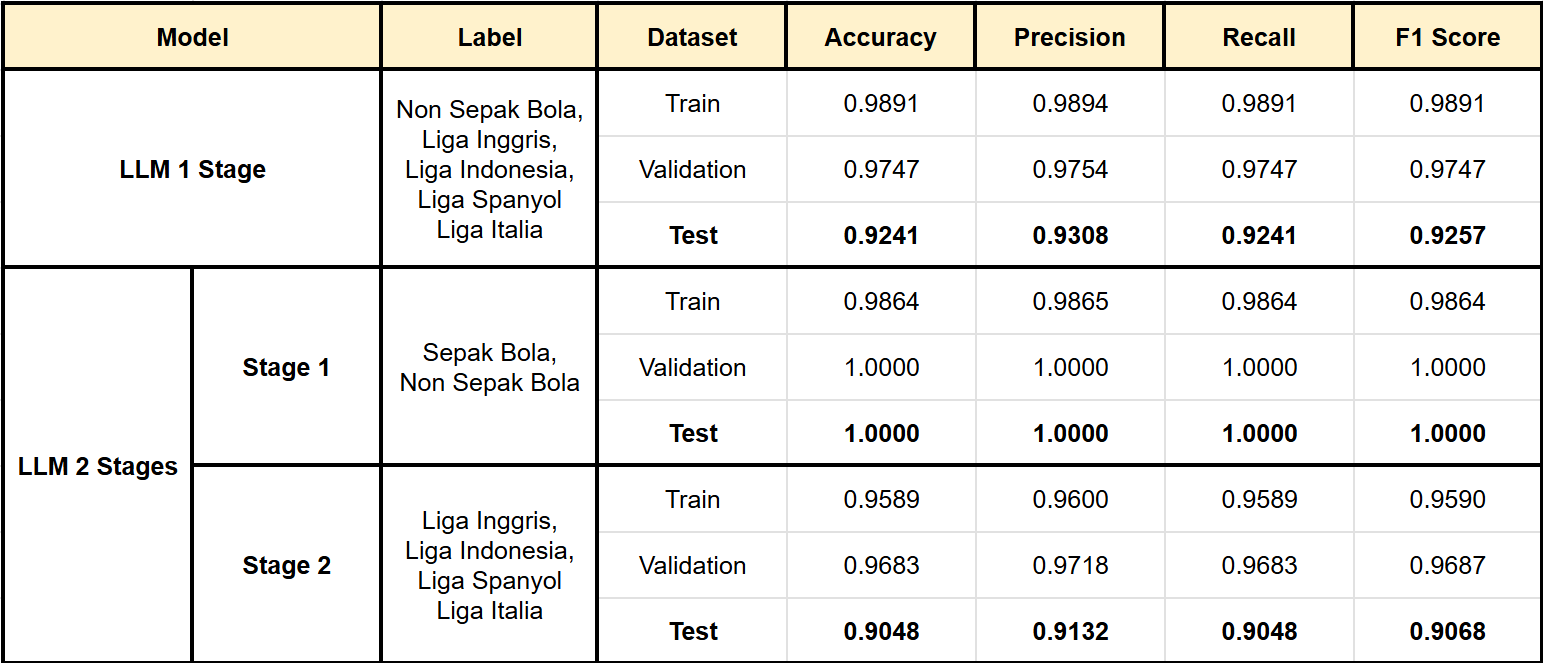

### **Analisis Performa Metrics**

#### **1. One Stage Model**
- **Training Metrics**:
  - Model menunjukkan performa yang sangat baik dengan accuracy dan F1-score di atas 98% pada data training.
  - Ini menandakan bahwa model berhasil belajar pola dengan baik pada data training.

- **Validation Metrics**:
  - Pada validation set, accuracy dan F1-score mencapai ~97.5%, menunjukkan model cukup baik dalam generalisasi ke data yang belum dilihat.

- **Testing Metrics**:
  - Model memiliki accuracy **92.41%** dan F1-score **92.57%** pada testing.
  - Meskipun sedikit menurun dibandingkan validation, ini menunjukkan kemampuan model yang cukup baik dalam menangani data unseen meskipun langsung mengklasifikasikan ke 5 label.

#### **2. Two Stages Model**
##### **Stage 1: Sepak Bola vs Non Sepak Bola**
- **Training Metrics**:
  - Accuracy dan F1-score mencapai **98.64%**, menunjukkan model sangat baik dalam memisahkan berita Sepak Bola dan Non Sepak Bola.
  
- **Validation Metrics**:
  - Accuracy dan F1-score sempurna di **100%**, menandakan tugas ini cukup sederhana untuk model.

- **Testing Metrics**:
  - Accuracy dan F1-score juga **100%**, memastikan bahwa **Stage 1 berhasil sempurna**, dan tidak ada kesalahan yang dibawa ke Stage 2.

##### **Stage 2: Liga Inggris, Liga Indonesia, Liga Spanyol, Liga Italia**
- **Training Metrics**:
  - Accuracy **95.89%** dan F1-score **95.90%**, menunjukkan bahwa model cukup baik dalam membedakan antara 4 label spesifik.

- **Validation Metrics**:
  - Accuracy meningkat ke **96.83%**, yang menunjukkan generalisasi lebih baik pada validation data dibandingkan training.

- **Testing Metrics**:
  - Accuracy turun menjadi **90.48%**, dengan F1-score **90.68%**. Penurunan ini disebabkan oleh tantangan dalam membedakan antara liga, terutama karena pola teks antar liga seperti Liga Inggris dan Liga Spanyol yang sering kali mirip.

---

### **Analisis Lebih Dalam**
1. **One Stage Model**:
   - Lebih efisien karena langsung mengklasifikasikan 5 label tanpa pembagian tahap.
   - Performanya lebih tinggi pada testing (~92%), menunjukkan bahwa model cukup baik dalam menangani tugas multi-label secara langsung.

2. **Two Stages Model**:
   - **Stage 1** sangat sukses dengan 100% metrics, tetapi tugas di Stage 2 lebih sulit karena harus membedakan 4 label dengan pola yang sering kali mirip.
   - Distribusi data yang tidak sepenuhnya seimbang antar label juga memengaruhi performa model di Stage 2.

3. **Kesimpulan Testing**:
   - Testing metrics di Stage 2 lebih rendah (90%) dibandingkan **One Stage Model** (92%), menandakan bahwa pendekatan Two Stages tidak memberikan keuntungan tambahan dalam performa klasifikasi akhir.

---

### **Kesimpulan**
- **One Stage Model** adalah pilihan yang lebih baik untuk tugas ini karena lebih sederhana dan memiliki testing accuracy yang lebih tinggi.
- **Two Stages Model** efektif untuk memisahkan berita Sepak Bola vs Non Sepak Bola, tetapi tidak memberikan peningkatan pada klasifikasi detail di Stage 2.
- Jika efisiensi dan performa menjadi prioritas, **One Stage Model** adalah solusi terbaik. Namun, jika tugas awal (filtering) menjadi fokus utama, **Two Stages Model** tetap relevan.

## Confusion Matrix

### One Stage

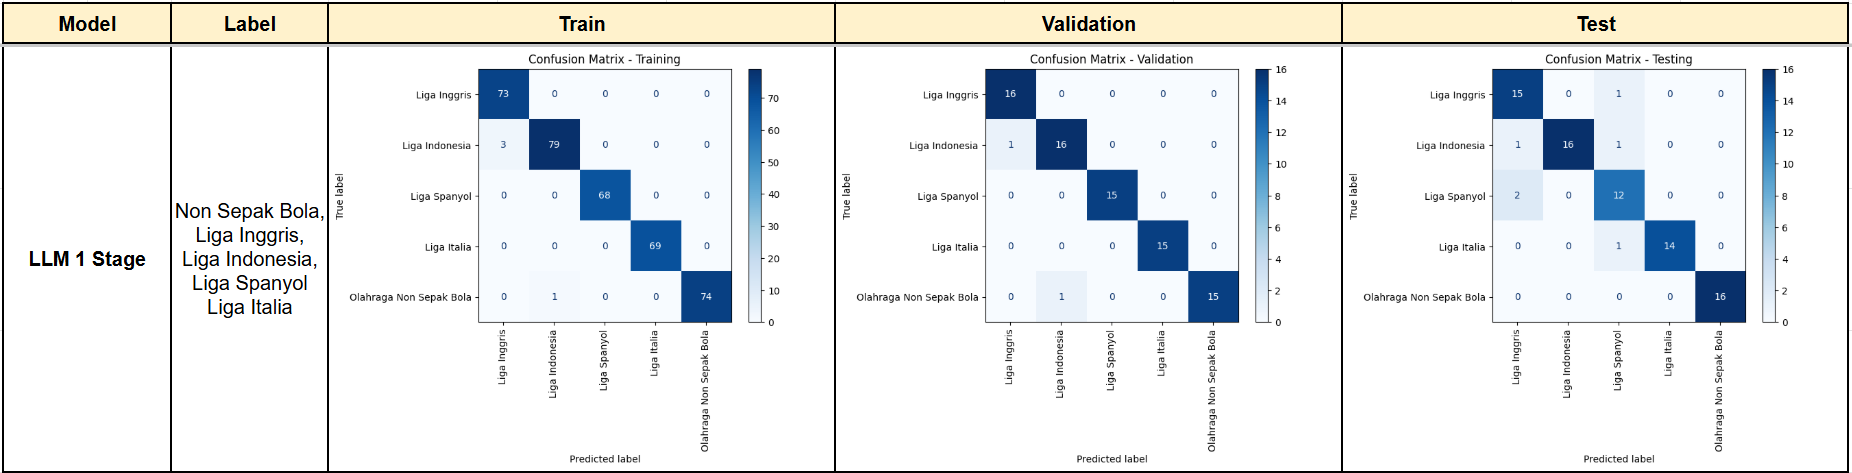

#### **LLM 1 Stage**
1. **Training:**
   - Model bekerja dengan sangat baik pada data training. Hampir semua kategori diprediksi dengan akurat, meskipun ada beberapa kesalahan kecil.
   - **Hal menarik:** Kesalahan utama terjadi pada *Liga Indonesia*, di mana beberapa data salah diklasifikasikan sebagai *Liga Inggris*. Ini menunjukkan adanya overlap fitur antar kategori sepak bola dari wilayah berbeda.

2. **Validation:**
   - Model berhasil mempertahankan performa tinggi. Hampir tidak ada kesalahan besar kecuali sedikit kebingungan antara *Liga Indonesia* dan *Olahraga Non Sepak Bola*.
   - **Hal menarik:** Kesalahan ini memperlihatkan bahwa kategori yang berbeda sepenuhnya (*sepak bola* dan *non sepak bola*) masih bisa sedikit membingungkan model, meskipun hanya terjadi satu atau dua kali.

3. **Testing:**
   - Pada data testing, performa model tetap baik dengan akurasi tinggi (92.41%), tetapi mulai terlihat penurunan dalam membedakan antar liga sepak bola.
   - **Hal menarik:** *Liga Spanyol* sering salah diklasifikasikan sebagai *Liga Inggris*. Ini mungkin disebabkan karena gaya bahasa berita atau istilah yang mirip antara kedua liga.

---

### Two Stages

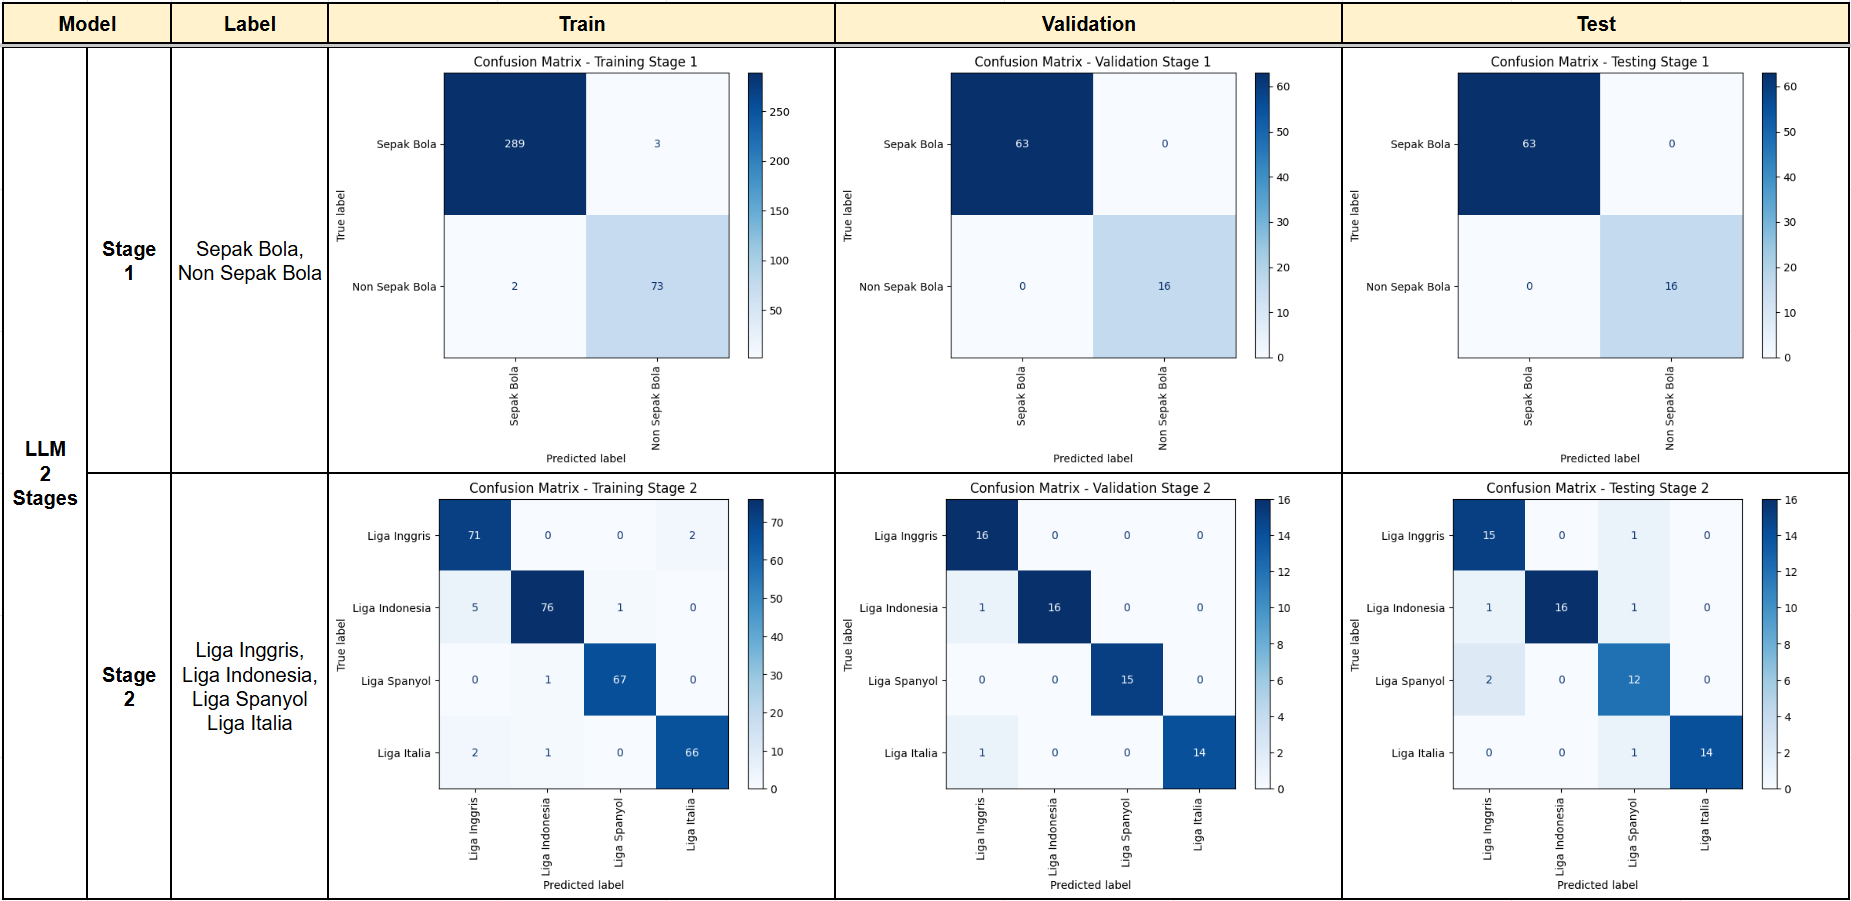

#### **LLM 2 Stage**
1. **Stage 1 (Sepak Bola vs Non Sepak Bola):**
   - **Training:** Performa sangat baik, meskipun terdapat sedikit kesalahan di data training. Dua data *Non Sepak Bola* salah diklasifikasikan sebagai *Sepak Bola* dan tiga data *Sepak Bola* salah diklasifikasikan sebagai *Non Sepak Bola*.
   - **Validation & Testing:** Pada tahap ini, model mencapai akurasi sempurna (100%). Tidak ada kesalahan dalam memisahkan kategori *Sepak Bola* dan *Non Sepak Bola*.
   - **Hal menarik:** Model mampu memisahkan dua kategori besar ini dengan sangat baik, menunjukkan pemahaman yang kuat tentang perbedaan fitur antar kategori.

2. **Stage 2 (Kategori Sepak Bola):**
   - **Training:** Model bekerja cukup baik pada data training. Namun, kesalahan terbesar terjadi ketika *Liga Indonesia* sering salah diklasifikasikan sebagai *Liga Inggris*. Ini menunjukkan bahwa fitur antar liga lokal dan internasional mungkin memiliki kemiripan yang membingungkan model.
   - **Validation:** Performa tetap solid, dengan sedikit kesalahan antara *Liga Inggris* dan *Liga Indonesia*. Hal ini menarik karena menunjukkan bahwa bahkan pada data validasi, kategori antar liga dapat overlap.
   - **Testing:** Pada data testing, akurasi menurun dibandingkan Stage 1, terutama pada *Liga Spanyol*, yang sering salah diklasifikasikan sebagai *Liga Inggris*.
   - **Hal menarik:** Kesalahan utama pada antar liga sepak bola ini mengindikasikan bahwa kategori dengan fitur yang mirip (seperti *Spanyol* dan *Inggris*) membutuhkan data tambahan atau pendekatan yang lebih spesifik untuk ditangani dengan lebih baik.

---

### **Kesimpulan**
1. **LLM 1 Stage:**
   - **Kelebihan:** Performa lebih stabil di semua dataset, dengan akurasi testing mencapai 92.41%. Model ini cocok untuk dataset kecil atau kasus sederhana karena tidak membutuhkan pemisahan tahap klasifikasi.
   - **Kekurangan:** Mengalami kesalahan lebih banyak pada kategori dengan fitur yang mirip, seperti antar liga sepak bola.

2. **LLM 2 Stage:**
   - **Kelebihan:** Pendekatan hierarkis memberikan struktur klasifikasi yang lebih baik. Stage 1 berhasil memisahkan *Sepak Bola* dan *Non Sepak Bola* dengan sempurna, menciptakan dasar yang kuat untuk Stage 2.
   - **Kekurangan:** Akurasi testing Stage 2 lebih rendah (90.48%), terutama karena kebingungan antar liga sepak bola yang mirip. Pendekatan ini lebih cocok untuk dataset besar dengan banyak kategori.

Pendekatan LLM 1 Stage lebih unggul untuk kasus ini karena menunjukkan performa yang lebih baik pada data testing, dengan akurasi, precision, recall, dan F1-score yang lebih tinggi dibandingkan LLM 2 Stages. Meskipun LLM 2 Stages berhasil memisahkan kategori utama dengan sempurna pada Stage 1, kompleksitas tambahan dari pendekatan bertingkat menyebabkan kesalahan antar subkategori yang lebih tinggi. Oleh karena itu, pendekatan LLM 1 Stage direkomendasikan untuk digunakan dalam skenario ini karena lebih sederhana dan memberikan hasil yang lebih akurat.